In [1]:
import shapefile
import json
import folium
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from scipy.stats import linregress
from shapely.geometry import Polygon
from matplotlib.ticker import ScalarFormatter

## 서울 행정동 영역 데이터 지도 시각화

In [22]:
# EPSG:5181 좌표계를 WGS84(EPSG:4326)로 변환하는 변환기 생성
transformer = Transformer.from_crs("epsg:5181", "epsg:4326", always_xy=True)

# 좌표 변환 함수 정의
def transform_coords(coords):
    return [transformer.transform(x, y) for x, y in coords]

# Shapefile 데이터 경로 설정
shapefile_path = 'data/상권 관련/약수/서울시 상권분석서비스(영역-행정동)/서울시 상권분석서비스(영역-행정동).shp'

# Shapefile 데이터를 읽기
reader = shapefile.Reader(shapefile_path)

# GeoJSON 형식으로 변환
fields = reader.fields[1:]
field_names = [field[0] for field in fields]
buffer = []

for sr in reader.shapeRecords():
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    if geom['type'] == 'Polygon':
        geom['coordinates'] = [transform_coords(geom['coordinates'][0])]
    elif geom['type'] == 'MultiPolygon':
        geom['coordinates'] = [
            [transform_coords(polygon[0]) for polygon in geom['coordinates']]
        ]
    buffer.append(dict(type="Feature", geometry=geom, properties=atr))

geojson = dict(type="FeatureCollection", features=buffer)

# 지도 생성
map_center = [37.5665, 126.9780]  # 서울 중심 좌표
seoul_map = folium.Map(location=map_center, zoom_start=12)

# GeoJSON 데이터를 folium에 추가
folium.GeoJson(
    geojson,
    name="geojson",
    tooltip=folium.GeoJsonTooltip(fields=["ADSTRD_NM"], aliases=["행정동: "])
).add_to(seoul_map)

# 지도 저장
seoul_map.save('seoul_administrative_tooltip.html')

## 서울 상권 영역 데이터 지도 시각화

In [ ]:
# EPSG:5181 좌표계를 WGS84(EPSG:4326)로 변환하는 변환기 생성
transformer = Transformer.from_crs("epsg:5181", "epsg:4326", always_xy=True)

# 좌표 변환 함수 정의
def transform_coords(geometry):
    if geometry.geom_type == 'Polygon':
        return gpd.GeoSeries([geometry]).set_crs(epsg=5181).to_crs(epsg=4326).values[0]
    elif geometry.geom_type == 'MultiPolygon':
        return gpd.GeoSeries([geometry]).set_crs(epsg=5181).to_crs(epsg=4326).values[0]
    else:
        return geometry

# Shapefile 데이터 경로 설정
market_shapefile_path = 'data/상권 관련/약수/서울시 상권분석서비스(영역-상권)/서울시 상권분석서비스(영역-상권).shp'

# 상권 Shapefile 데이터를 읽어 GeoDataFrame으로 변환
gdf = gpd.read_file(market_shapefile_path)

# 좌표계를 변환
gdf['geometry'] = gdf['geometry'].apply(transform_coords)

# GeoDataFrame을 GeoJSON 형식으로 변환
market_geojson = gdf.to_json()

# 지도 생성
map_center = [37.5665, 126.9780]  # 서울 중심 좌표
seoul_map = folium.Map(location=map_center, zoom_start=12)

# 상권 GeoJSON 데이터를 folium에 추가 (마우스 오버 시 상권명 표시)
folium.GeoJson(
    market_geojson,
    name="markets",
    tooltip=folium.GeoJsonTooltip(fields=["TRDAR_CD_N"], aliases=["상권명: "])
).add_to(seoul_map)

# 지도 저장
seoul_map.save('seoul_markets_tooltip.html')

## 서울 상권배후지 영역 데이터 지도 시각화

In [ ]:
# EPSG:5181 좌표계를 WGS84(EPSG:4326)로 변환하는 변환기 생성
transformer = Transformer.from_crs("epsg:5181", "epsg:4326", always_xy=True)

# 좌표 변환 함수 정의
def transform_coords(geometry):
    if geometry.geom_type == 'Polygon':
        return gpd.GeoSeries([geometry]).set_crs(epsg=5181).to_crs(epsg=4326).values[0]
    elif geometry.geom_type == 'MultiPolygon':
        return gpd.GeoSeries([geometry]).set_crs(epsg=5181).to_crs(epsg=4326).values[0]
    else:
        return geometry

# Shapefile 데이터 경로 설정
backzone_shapefile_path = 'data/상권 관련/약수/서울시 상권분석서비스(영역-상권배후지)/서울시 상권분석서비스(영역-상권배후지).shp'

# 상권 배후지 Shapefile 데이터를 읽어 GeoDataFrame으로 변환
gdf = gpd.read_file(backzone_shapefile_path)

# 좌표계를 변환
gdf['geometry'] = gdf['geometry'].apply(transform_coords)

# GeoDataFrame을 GeoJSON 형식으로 변환
backzone_geojson = gdf.to_json()

# 지도 생성
map_center = [37.5665, 126.9780]  # 서울 중심 좌표
seoul_map = folium.Map(location=map_center, zoom_start=12)

# 상권 배후지 GeoJSON 데이터를 folium에 추가 (마우스 오버 시 상권 배후지명 표시)
folium.GeoJson(
    backzone_geojson,
    name="backzones",
    tooltip=folium.GeoJsonTooltip(fields=["ALLEY_TR_1"], aliases=["상권 배후지명: "])
).add_to(seoul_map)

# 지도 저장
seoul_map.save('seoul_backzones_tooltip.html')

## 상권별 생활인구 데이터

In [2]:
data = pd.read_csv('data/상권 관련/약수/서울시 상권분석서비스(길단위인구-상권).csv', encoding='cp949')

In [3]:
# 필터링 조건 (지도에서 핀에 해당하는 상권 영역)
filter_list = ['버티고개', '다산성곽길', '약수역', '약수시장', '약수역 7번', '청구역 3번', '장충단 고개', '장충초등학교', '장충동주민센터', '청구역 1번', '신당역', '서울중앙시장(신중앙시장)', '백학시장']

# 조건에 맞는 데이터만 필터링
df = data[data['상권_코드_명'].isin(filter_list)]

In [4]:
df

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,...,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_24_유동인구_수,월요일_유동인구_수,화요일_유동인구_수,수요일_유동인구_수,목요일_유동인구_수,금요일_유동인구_수,토요일_유동인구_수,일요일_유동인구_수
274,20234,R,전통시장,3130053,백학시장,785223,378856,406366,78384,118593,...,113067,162150,99710,109063,110990,112306,112299,115492,116043,109032
275,20234,R,전통시장,3130052,서울중앙시장(신중앙시장),2019863,982847,1037016,149794,332005,...,279996,374868,247675,289094,290935,292316,292044,298064,289322,268088
282,20234,R,전통시장,3130042,약수시장,414647,195855,218791,48536,58666,...,64545,84970,48948,57597,58476,59242,59102,60829,60691,58710
521,20234,D,발달상권,3120039,신당역,2314714,1115270,1199444,141602,374845,...,317410,430814,303609,338634,351826,356311,355569,345793,287824,278758
522,20234,D,발달상권,3120038,약수역,1040170,494473,545697,129253,151884,...,141524,190927,128554,147193,149443,149893,151039,152807,147095,142700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32944,20191,A,골목상권,3110050,약수역 7번,245184,113378,131805,28535,32248,...,34020,48906,31811,34452,34290,34364,34616,34748,36396,36317
32945,20191,A,골목상권,3110049,장충단 고개,1116723,530526,586198,124165,199662,...,161966,220567,143362,163002,163947,164709,168450,167277,147986,141350
32946,20191,A,골목상권,3110048,장충동주민센터,823588,403945,419644,60826,158231,...,124365,146001,89325,120594,119820,123856,123516,120512,107840,107450
32947,20191,A,골목상권,3110047,다산성곽길,438570,204924,233646,46686,74500,...,44156,59961,54885,63245,62102,61993,60939,60002,63373,66914


In [5]:
# MZ세대_유동인구_수 컬럼 추가
df['MZ세대_유동인구_수'] = df['연령대_10_유동인구_수'] + df['연령대_20_유동인구_수'] + df['연령대_30_유동인구_수']

# 특정 열에 해당하는 데이터만 남기기
columns = ['기준_년분기_코드', '상권_코드_명', '총_유동인구_수', 'MZ세대_유동인구_수']
df = df[columns]

C:\Users\Puser\AppData\Local\Temp\ipykernel_10608\110089154.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MZ세대_유동인구_수'] = df['연령대_10_유동인구_수'] + df['연령대_20_유동인구_수'] + df['연령대_30_유동인구_수']


In [6]:
df

,기준_년분기_코드,상권_코드_명,총_유동인구_수,MZ세대_유동인구_수
274,20234,백학시장,785223,317433
275,20234,서울중앙시장(신중앙시장),2019863,855042
282,20234,약수시장,414647,183437
521,20234,신당역,2314714,975907
522,20234,약수역,1040170,477059
...,...,...,...,...
32944,20191,약수역 7번,245184,99318
32945,20191,장충단 고개,1116723,521428
32946,20191,장충동주민센터,823588,370446
32947,20191,다산성곽길,438570,198004


### 상권 전체 MZ세대 유동인구 수 추이

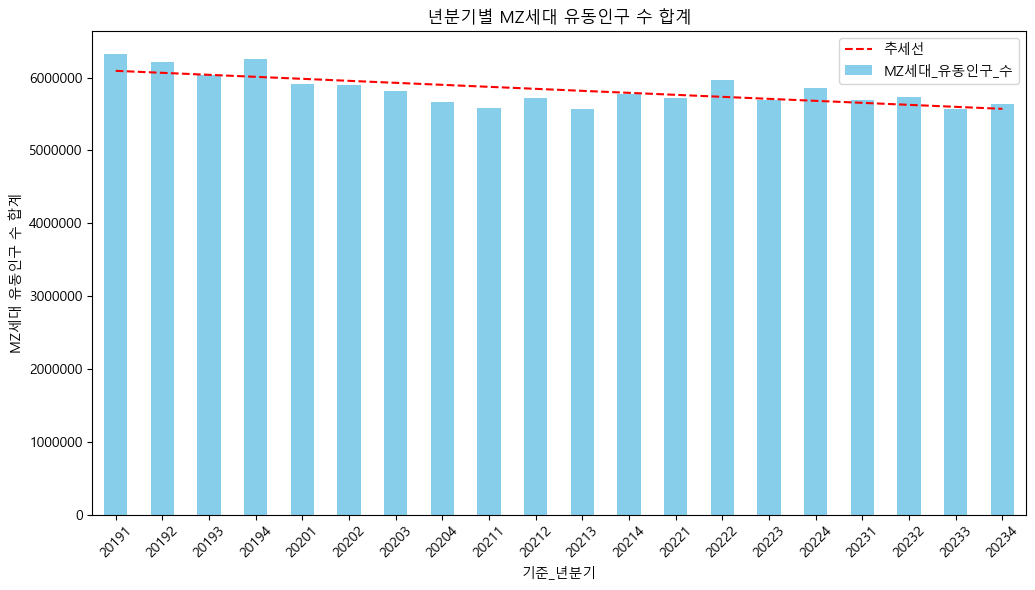

In [41]:
# 기준_년분기_코드별 MZ세대_유동인구_수 합계 계산
mz_sum_by_period = df.groupby('기준_년분기_코드')['MZ세대_유동인구_수'].sum()

# 그래프 시각화
plt.figure(figsize=(10, 6))
mz_sum_by_period.plot(kind='bar', color='skyblue')

# 추세선 추가
x = np.arange(len(mz_sum_by_period))
y = mz_sum_by_period.values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='추세선')

plt.title('년분기별 MZ세대 유동인구 수 합계')
plt.xlabel('기준_년분기')
plt.ylabel('MZ세대 유동인구 수 합계')
plt.xticks(rotation=45)
plt.tight_layout()

# Y축을 정수 형식으로 설정
y_formatter = ScalarFormatter(useOffset=False)
y_formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(y_formatter)

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

In [35]:
mz_sum_by_period

기준_년분기_코드
20191    6320270
20192    6221673
20193    6041004
20194    6258920
20201    5911679
20202    5893211
20203    5816737
20204    5664786
20211    5585296
20212    5717448
20213    5575567
20214    5774101
20221    5714541
20222    5967799
20223    5693403
20224    5858199
20231    5699092
20232    5739342
20233    5572902
20234    5633183
Name: MZ세대_유동인구_수, dtype: int64

### 상권별 MZ세대 유동인구 수 추이

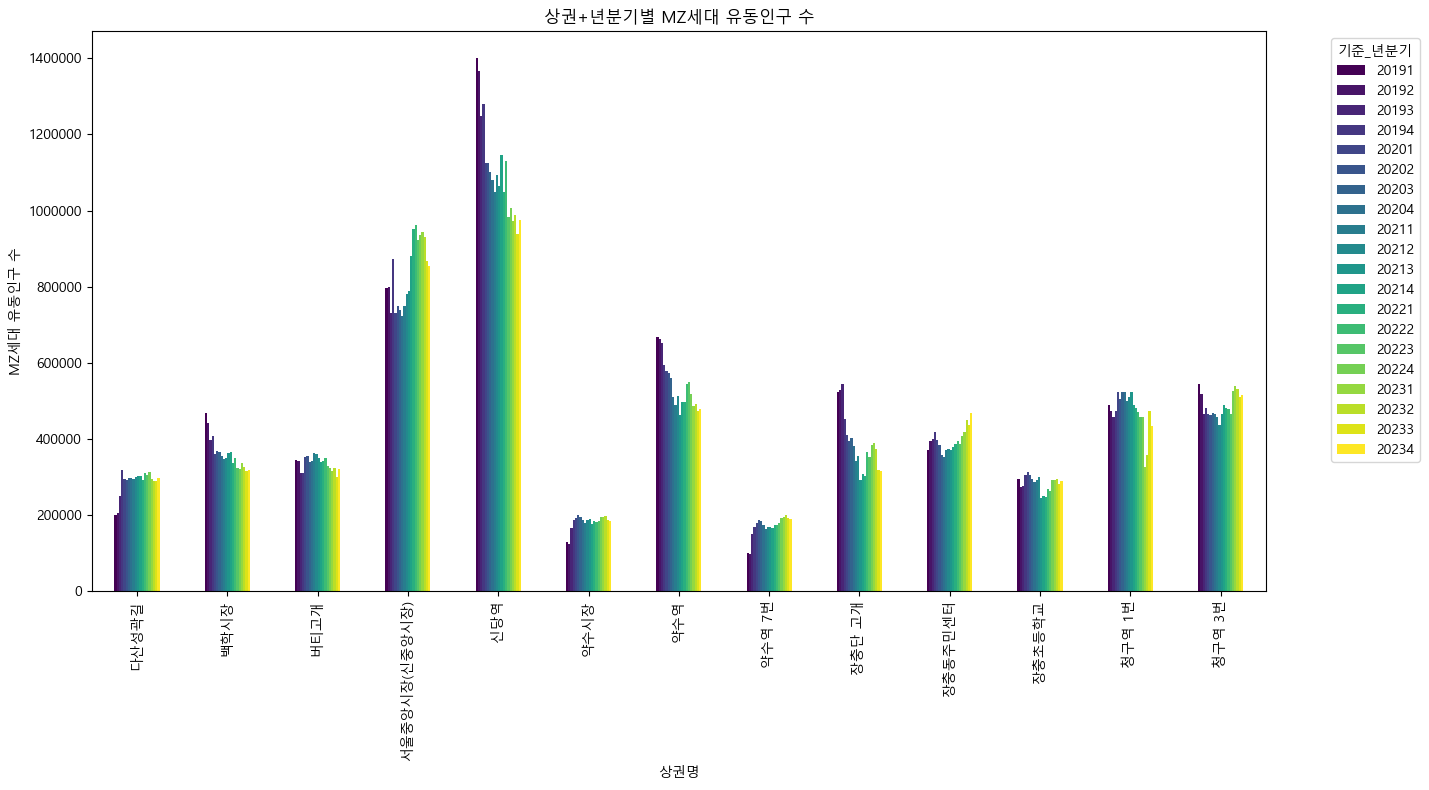

In [54]:
# 상권_코드_명, 기준_년분기_코드별 MZ세대 유동인구 수 합계 계산
mz_sum = df.groupby(['상권_코드_명', '기준_년분기_코드'])['MZ세대_유동인구_수'].sum().unstack()

# 그래프 시각화
mz_sum.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('상권+년분기별 MZ세대 유동인구 수')
plt.xlabel('상권명')
plt.ylabel('MZ세대 유동인구 수')
plt.legend(title='기준_년분기', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Y축을 정수 형식으로 설정
y_formatter = ScalarFormatter(useOffset=False)
y_formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(y_formatter)

# 그래프를 이미지 파일로 저장
plt.savefig('mz_population.png')

# 그래프 출력
plt.show()

C:\Users\Puser\AppData\Local\Temp\ipykernel_4488\338114193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['기준_년분기_코드'] = df['기준_년분기_코드'].astype(str)


다산성곽길: 추세가 증가하는 경향을 보입니다.


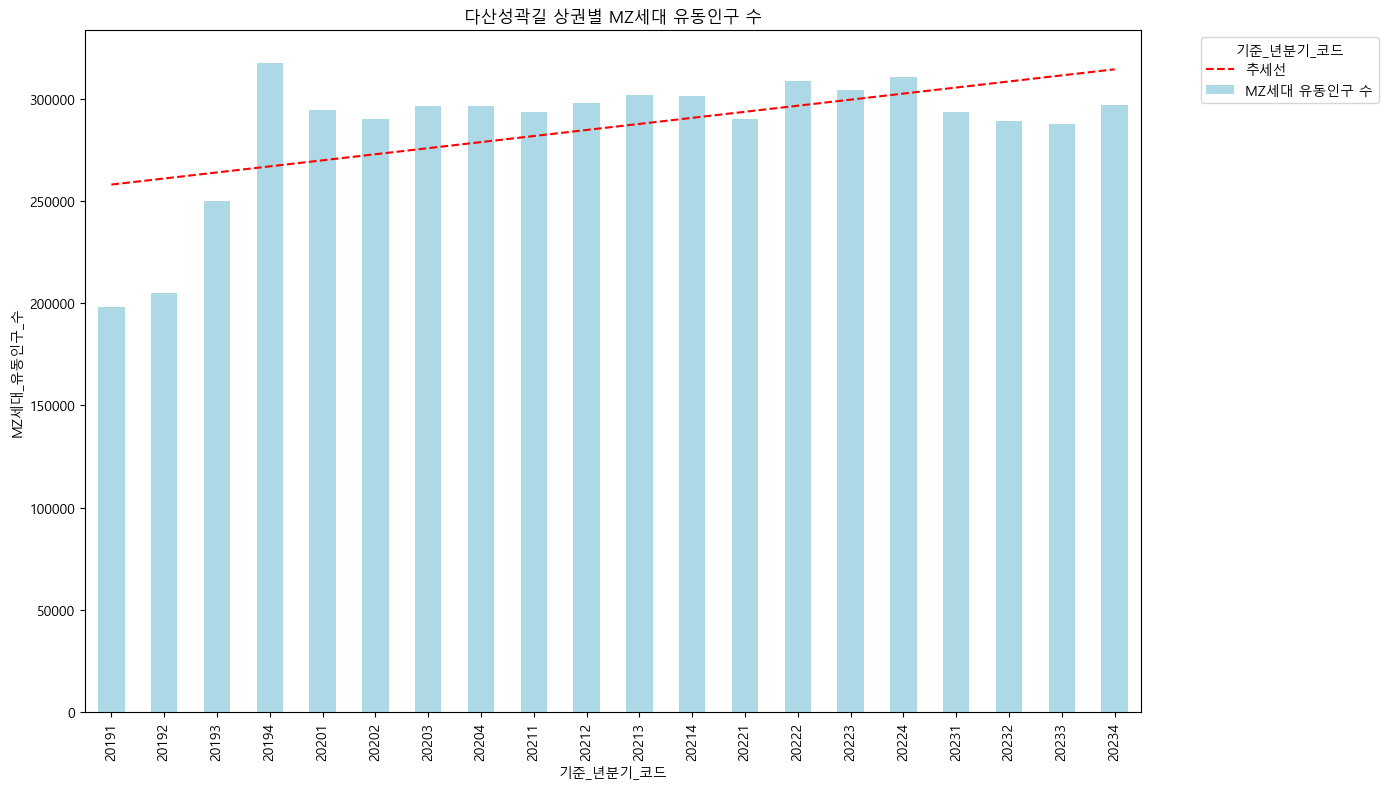

백학시장: 추세가 감소하는 경향을 보입니다.


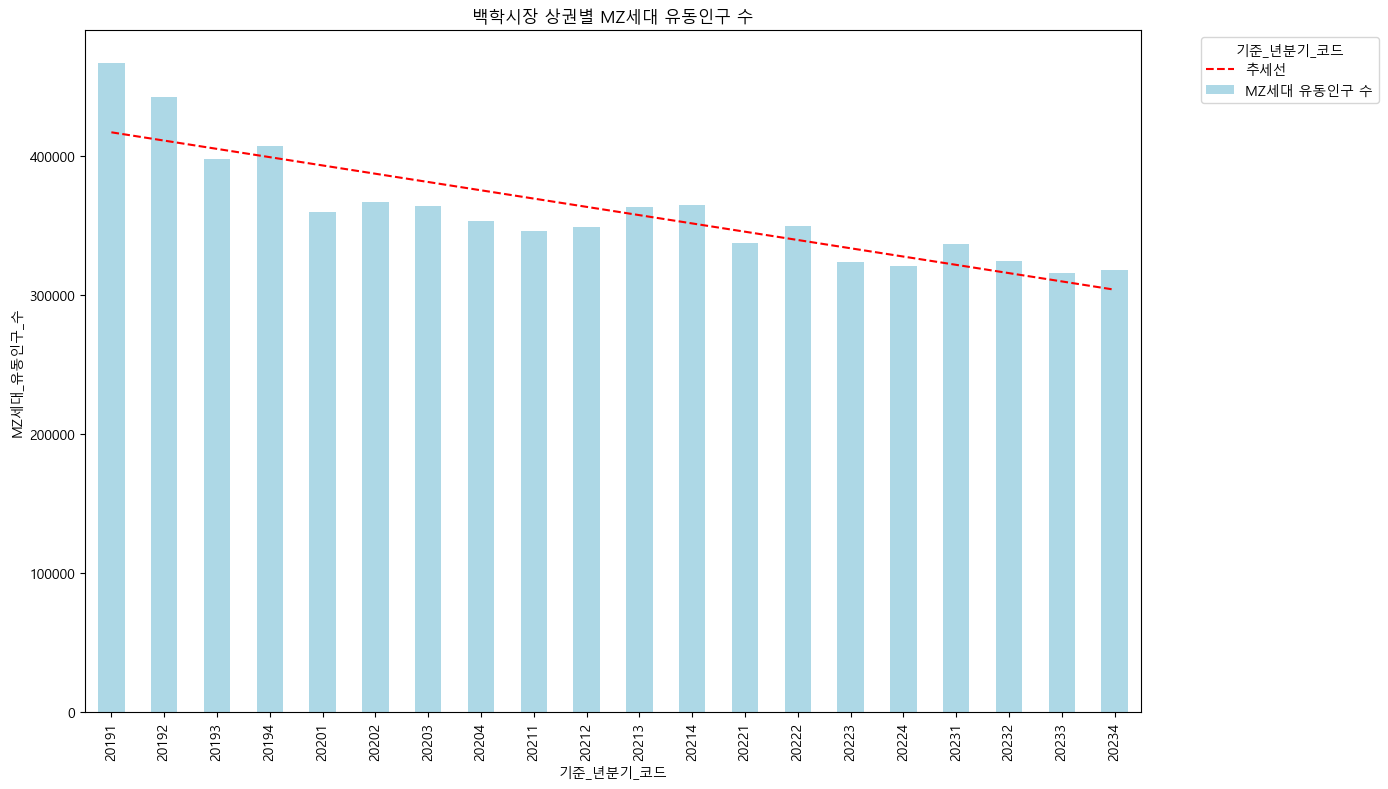

버티고개: 추세가 감소하는 경향을 보입니다.


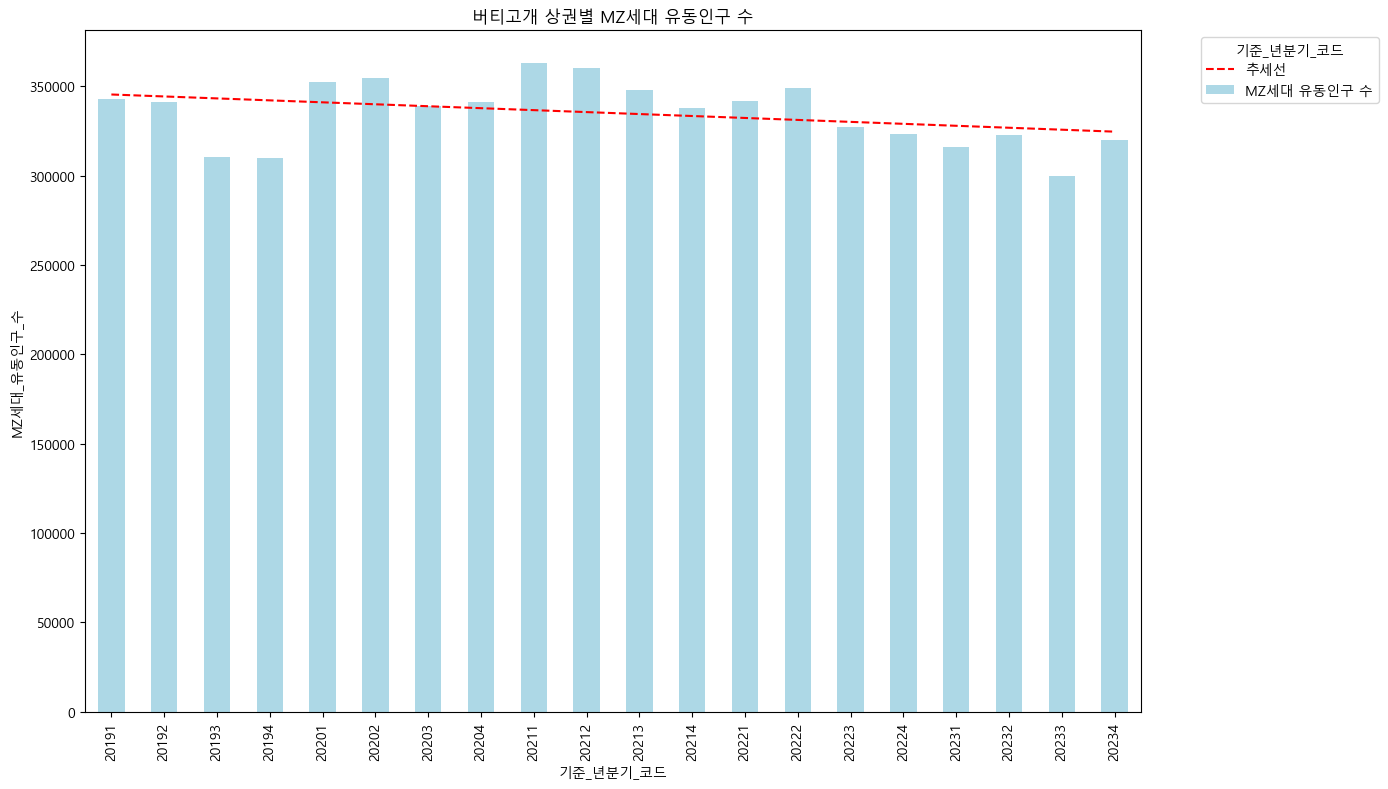

서울중앙시장(신중앙시장): 추세가 증가하는 경향을 보입니다.


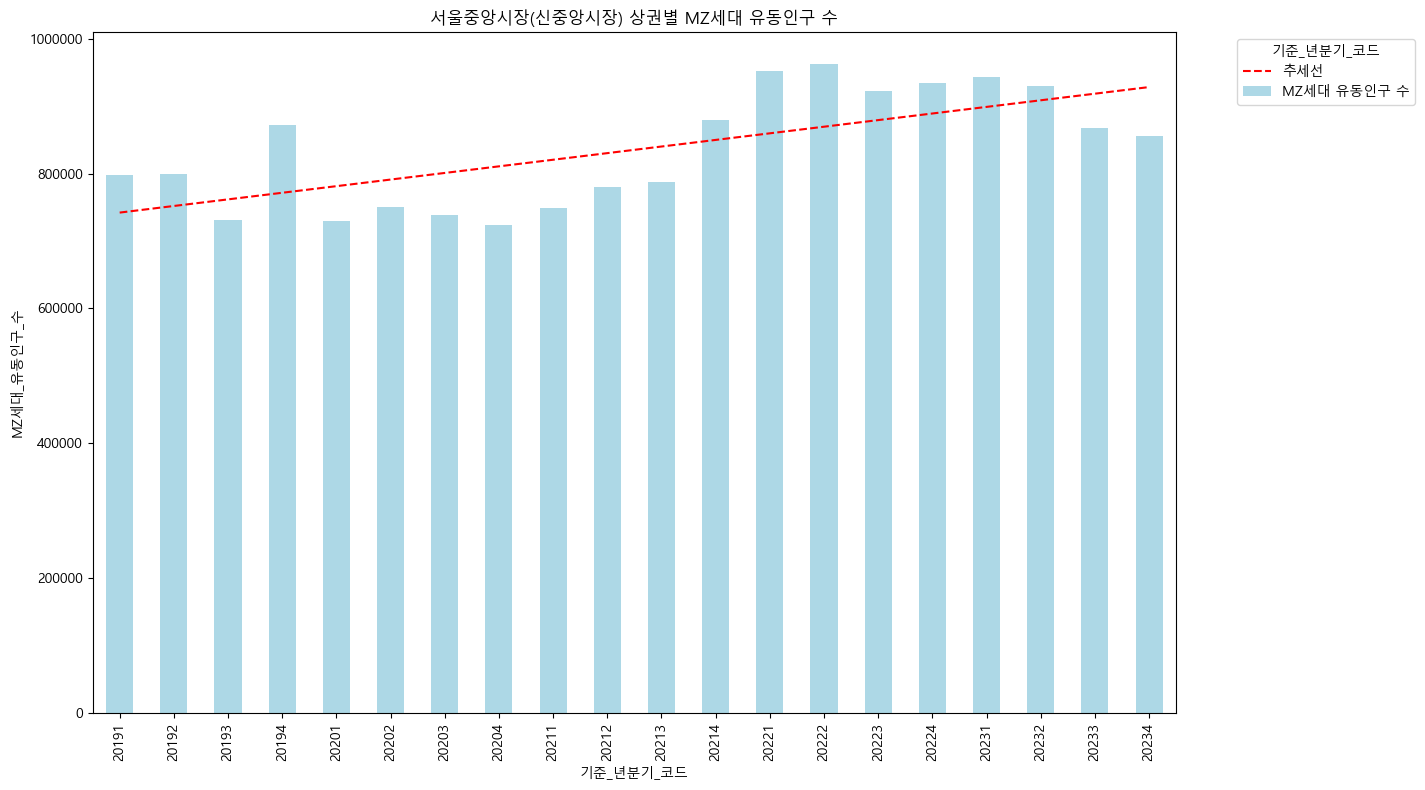

신당역: 추세가 감소하는 경향을 보입니다.


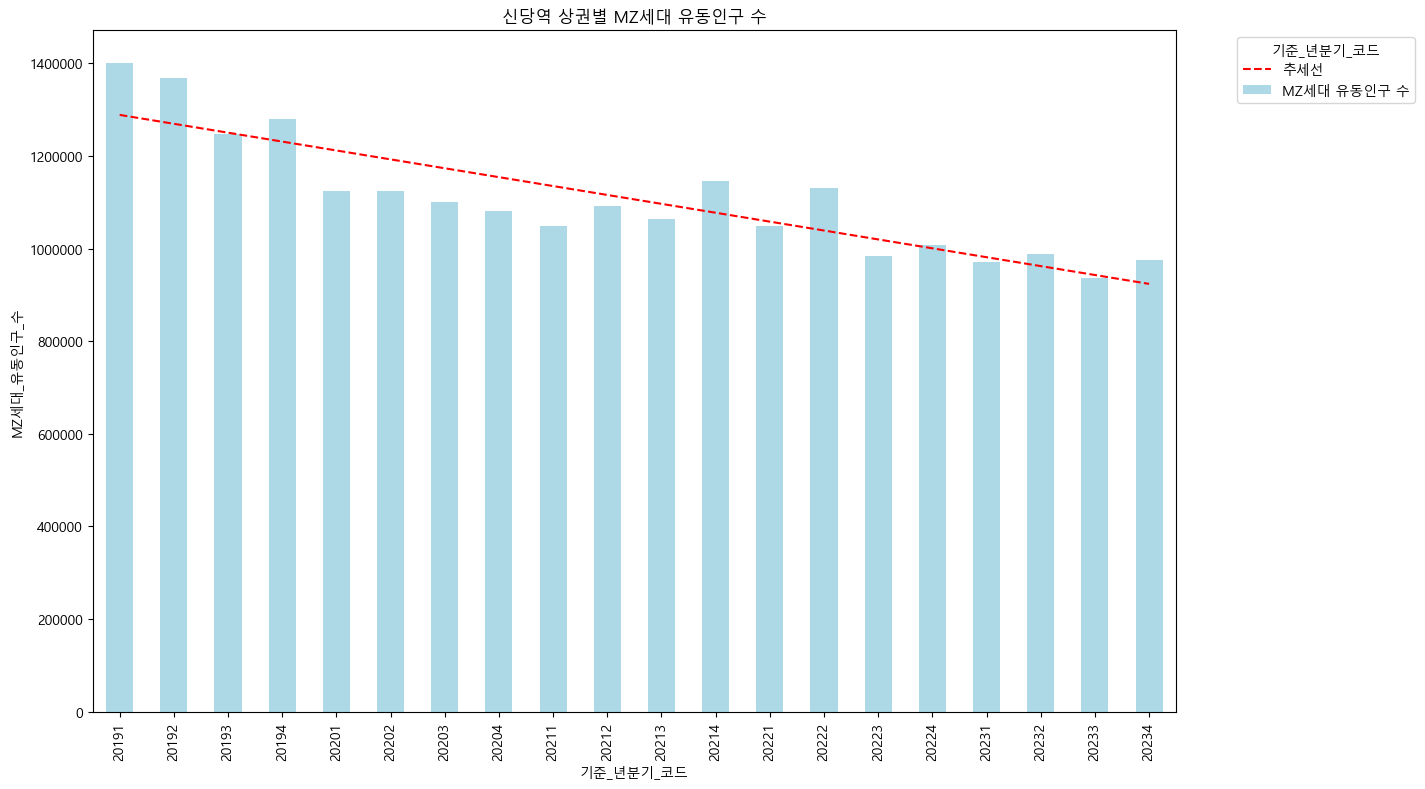

약수시장: 추세가 증가하는 경향을 보입니다.


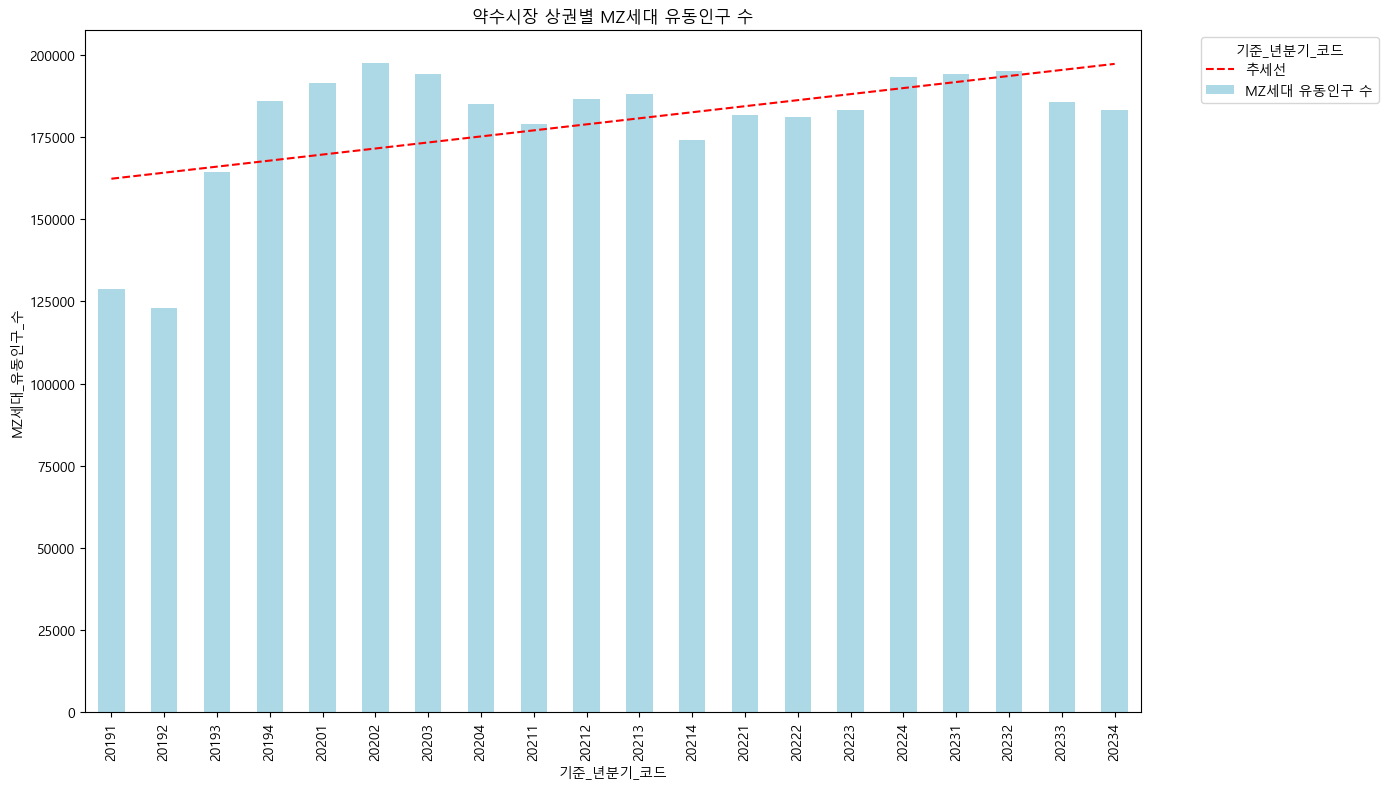

약수역: 추세가 감소하는 경향을 보입니다.


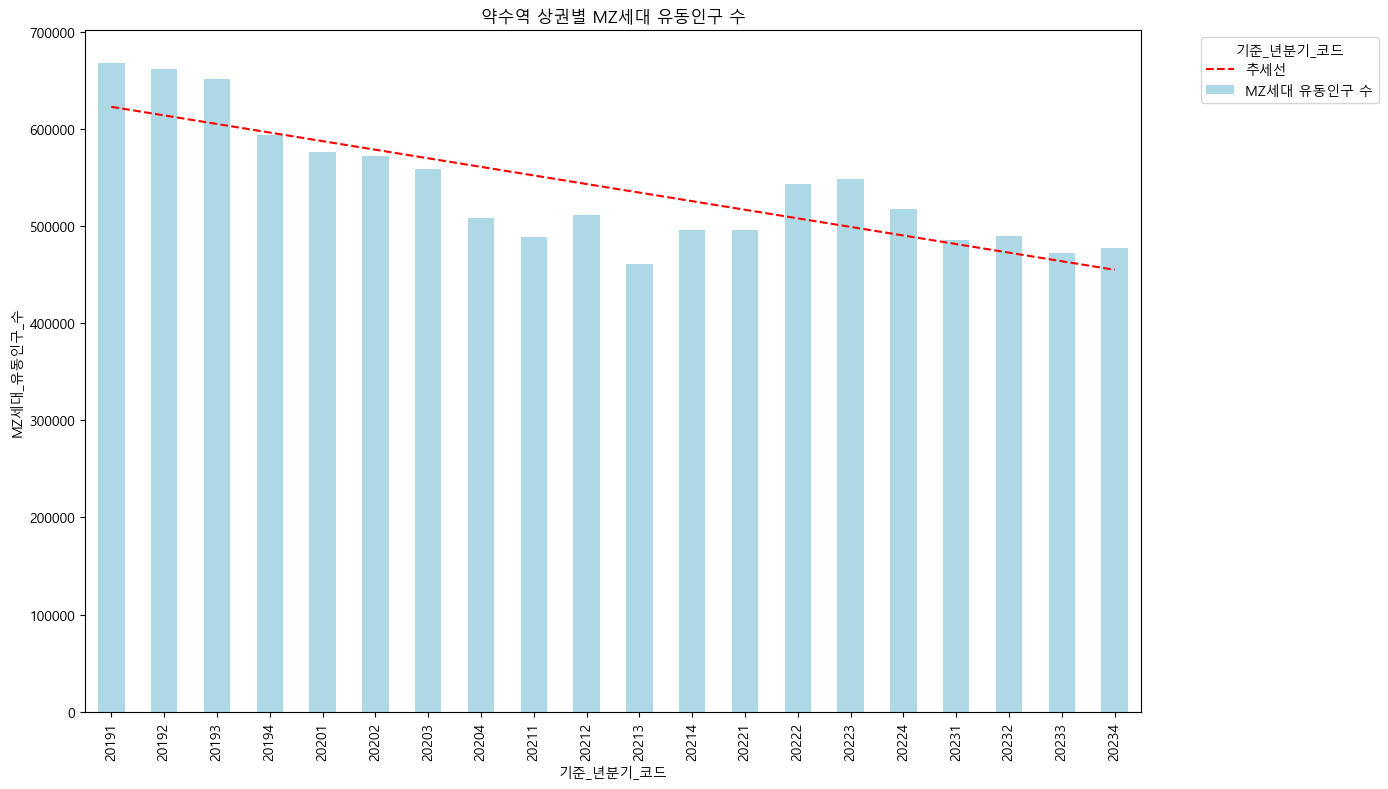

약수역 7번: 추세가 증가하는 경향을 보입니다.


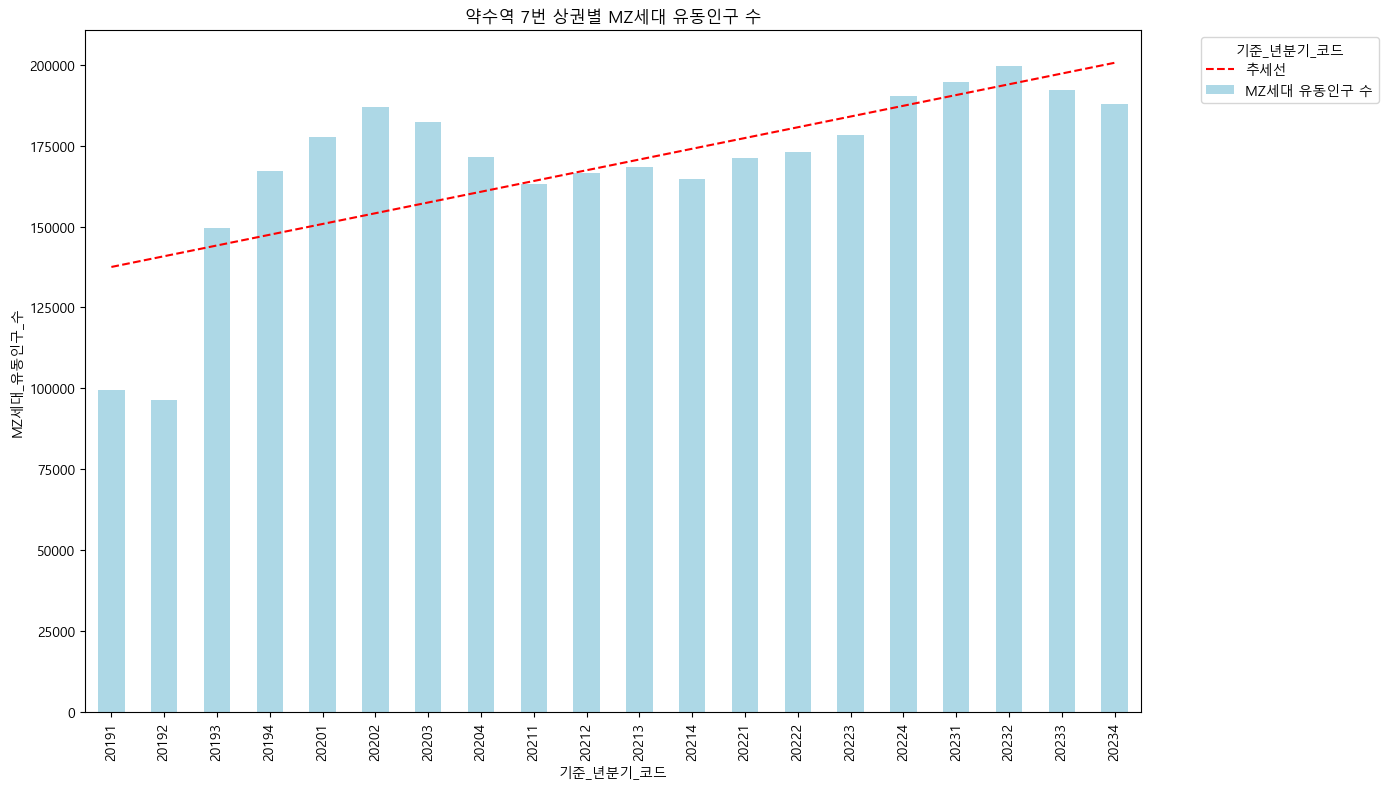

장충단 고개: 추세가 감소하는 경향을 보입니다.


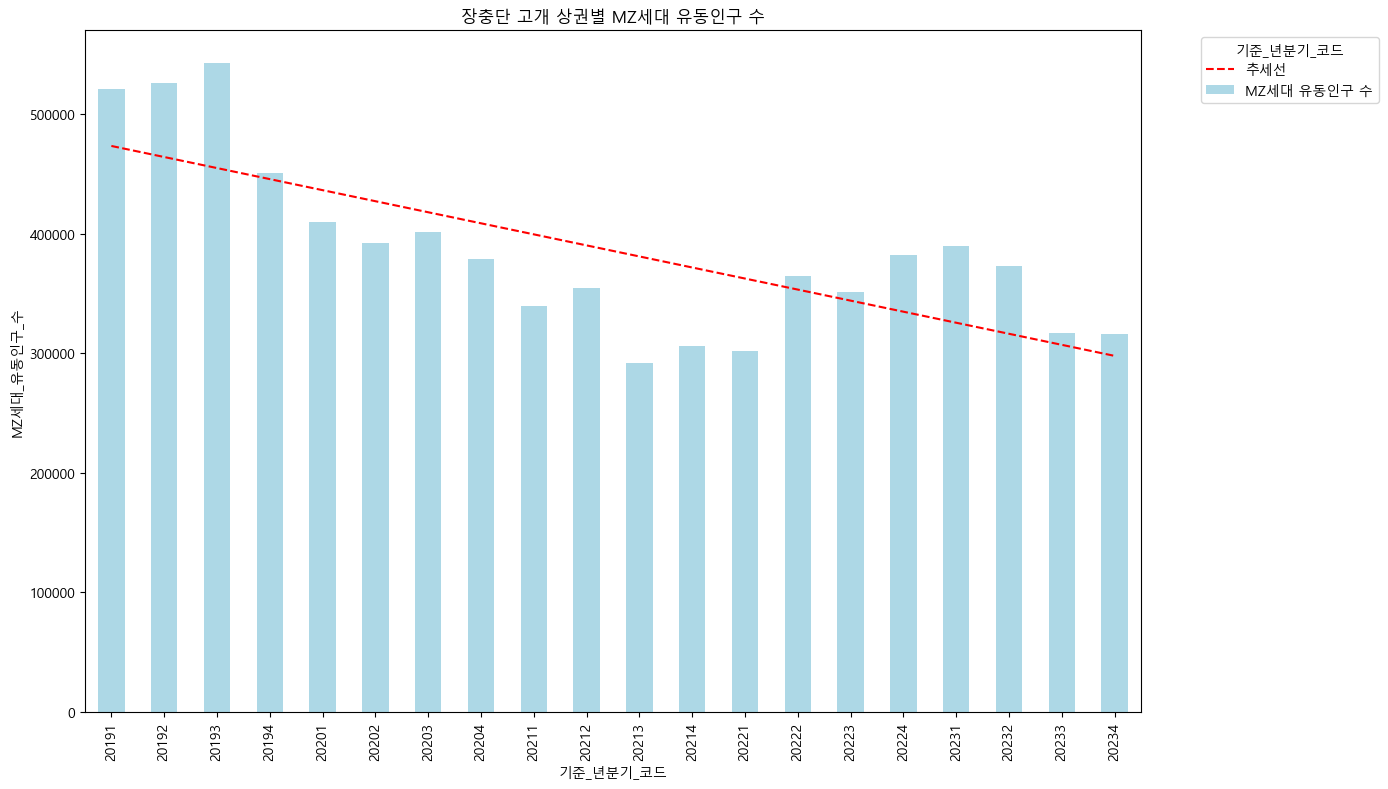

장충동주민센터: 추세가 증가하는 경향을 보입니다.


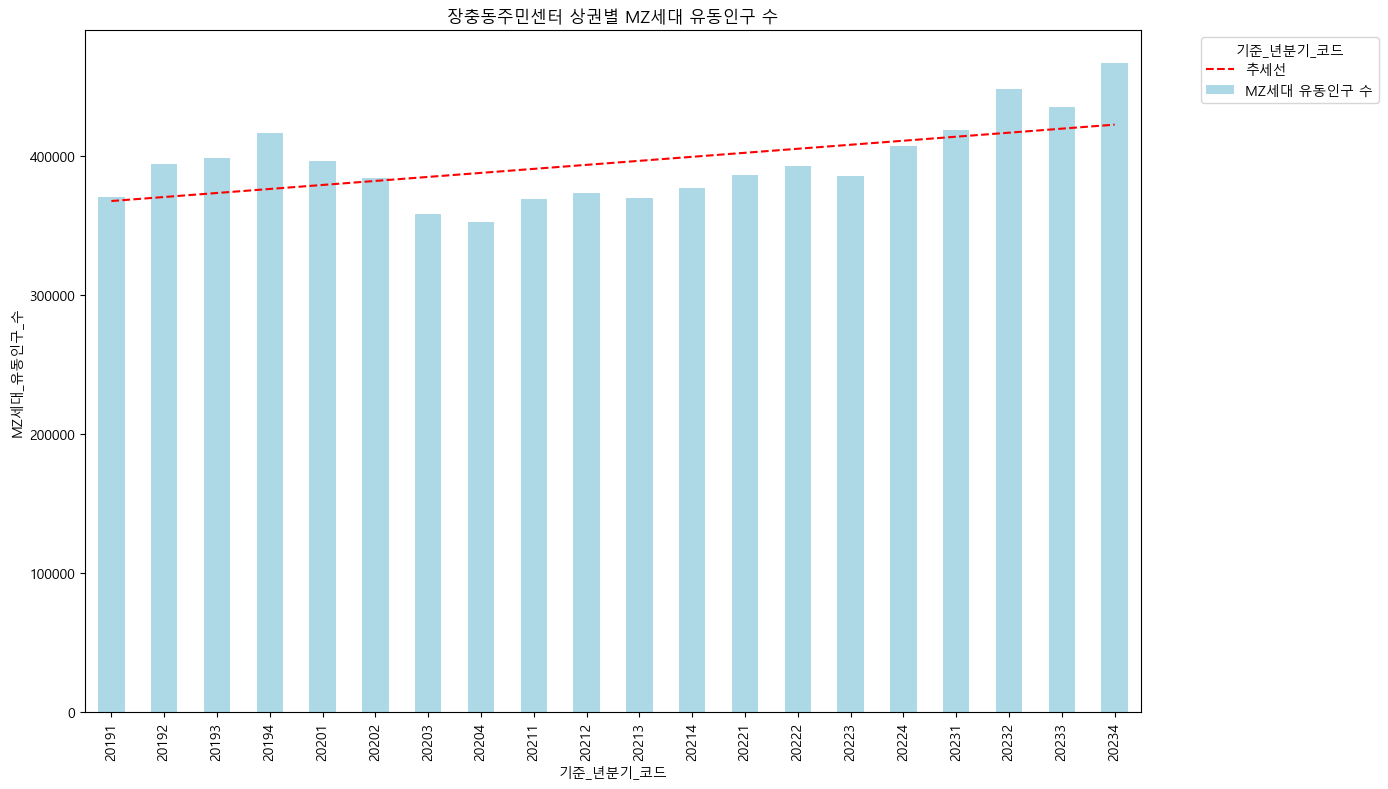

장충초등학교: 추세가 감소하는 경향을 보입니다.


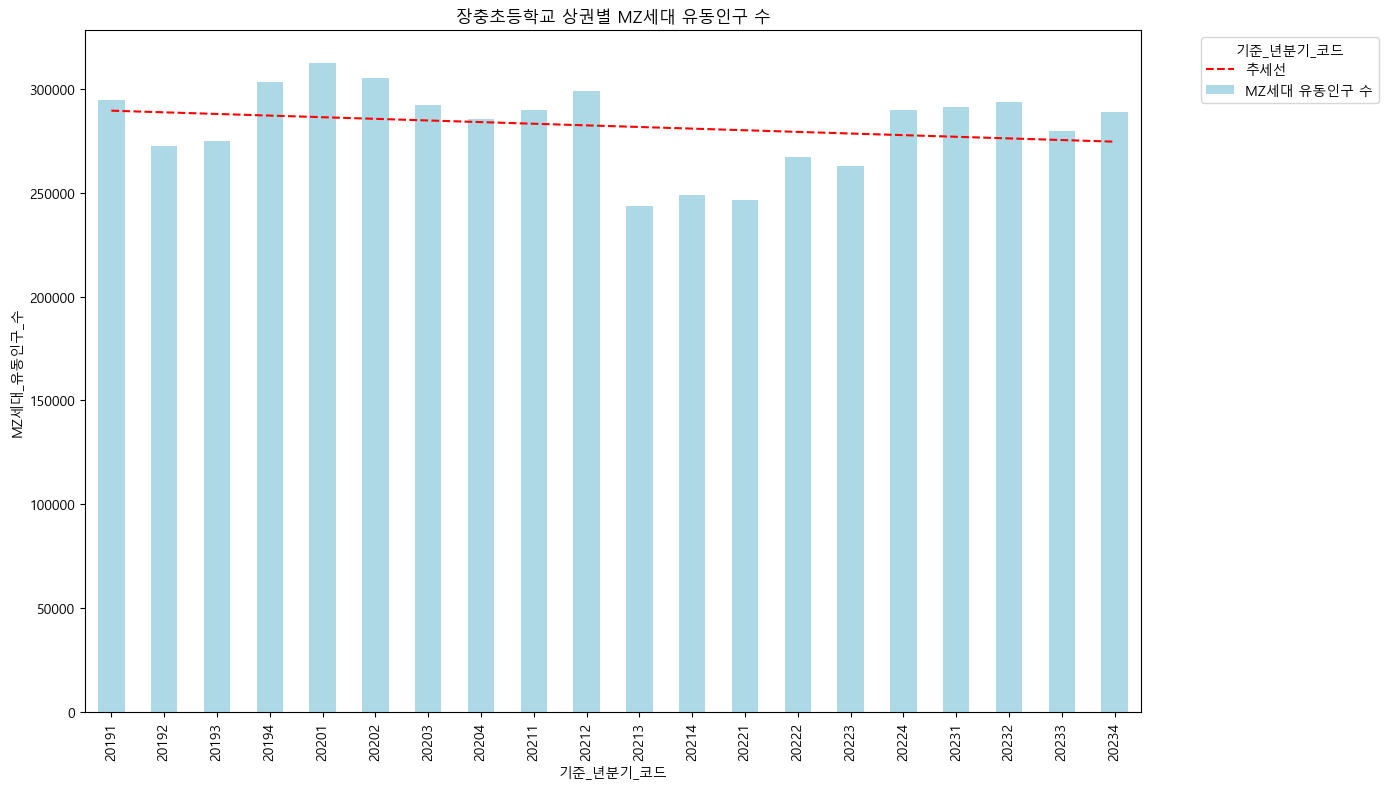

청구역 1번: 추세가 감소하는 경향을 보입니다.


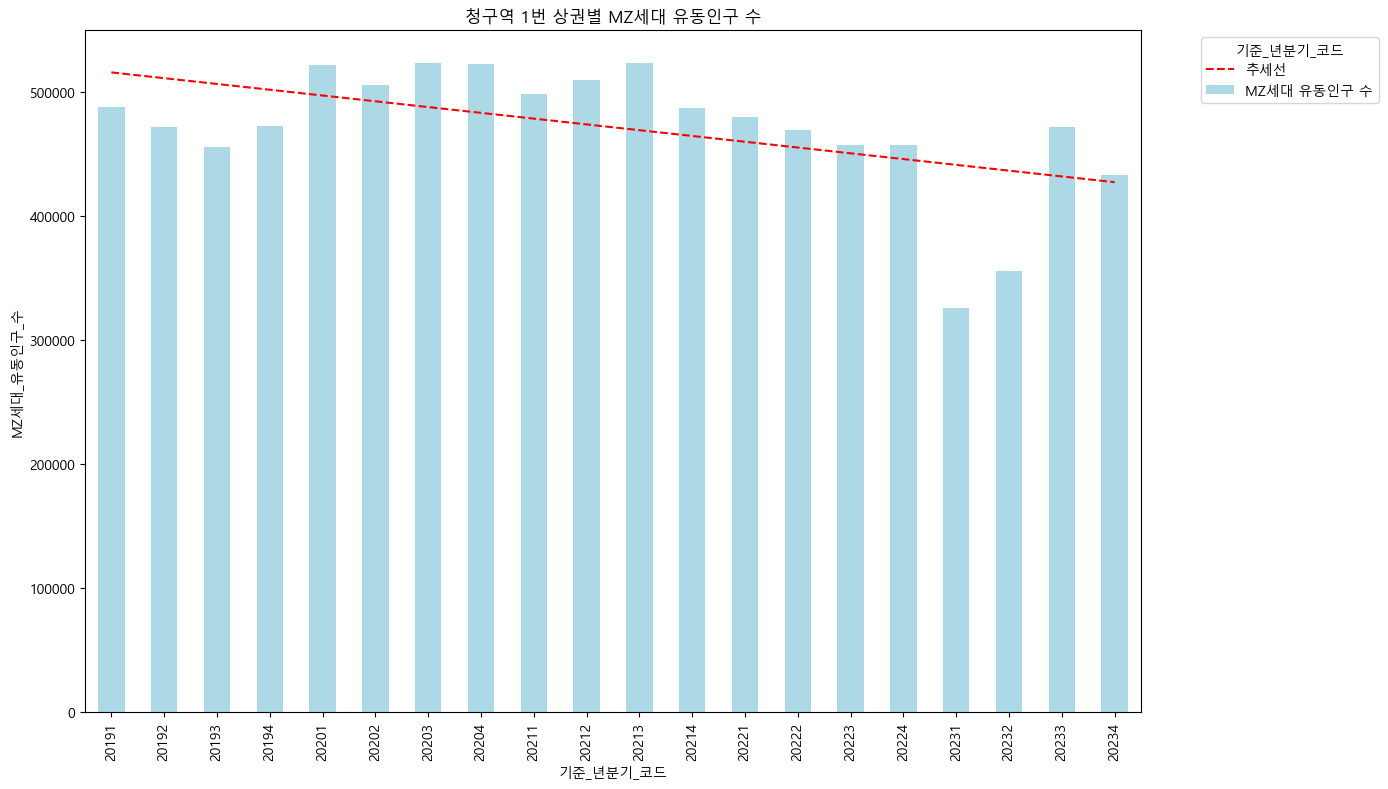

청구역 3번: 추세가 증가하는 경향을 보입니다.


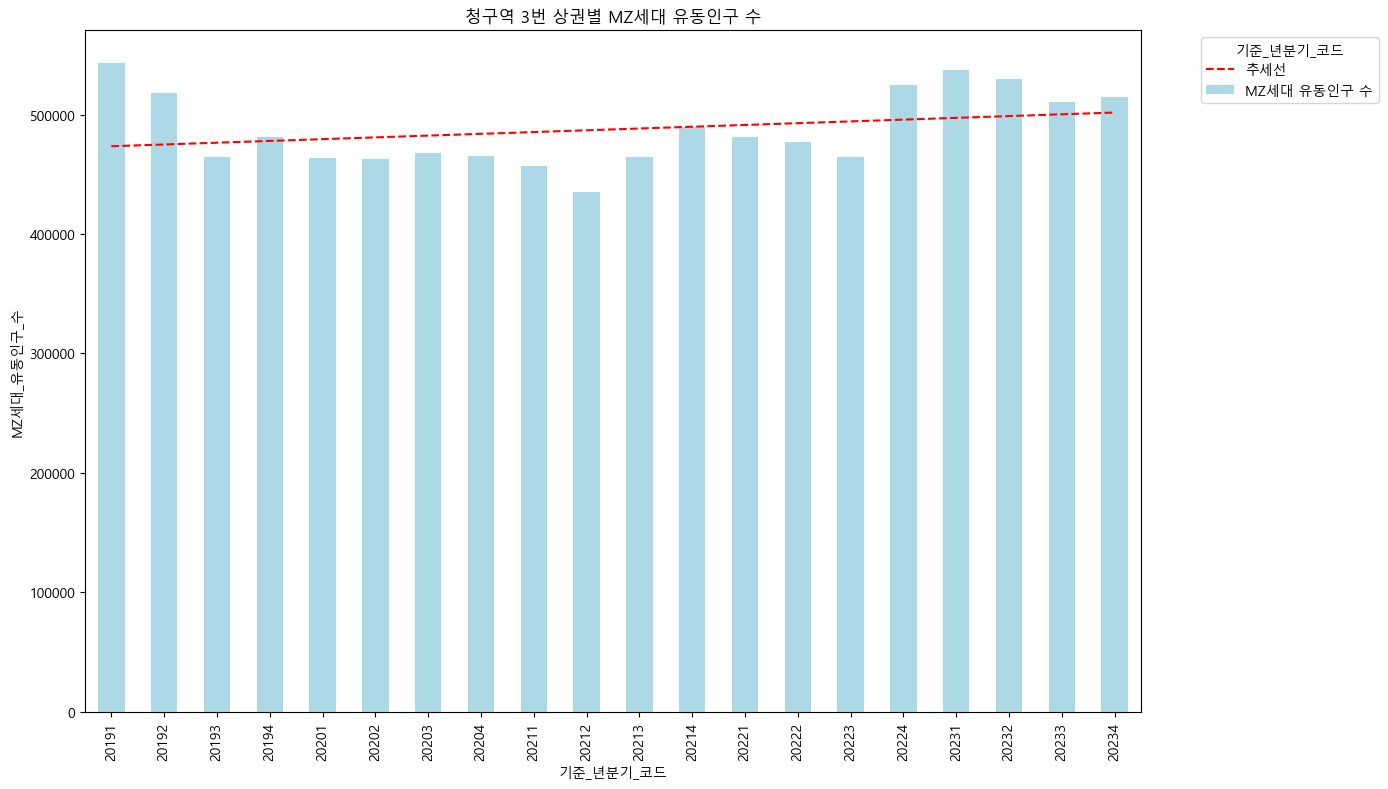

In [12]:
# 기준_년분기_코드를 문자열로 변환
df['기준_년분기_코드'] = df['기준_년분기_코드'].astype(str)

# 상권_코드_명별, 기준_년분기_코드별 MZ세대_유동인구_수 합계 계산
total = df.groupby(['상권_코드_명', '기준_년분기_코드'])['MZ세대_유동인구_수'].sum().unstack()

# 상권_코드_명별로 개별 그래프 생성
for name, group in total.iterrows():
    plt.figure(figsize=(14, 8))
    group.plot(kind='bar', color='lightblue', label='MZ세대 유동인구 수')

    # 추세선 추가 (예외 처리 포함)
    try:
        x = np.arange(len(group.index))
        y = group.values

        # 데이터 정규화
        x_norm = (x - np.mean(x)) / np.std(x)
        y_norm = (y - np.mean(y)) / np.std(y)

        z = np.polyfit(x_norm, y_norm, 1)
        p = np.poly1d(z)
        plt.plot(group.index, np.polyval(z, x_norm) * np.std(y) + np.mean(y), "r--", label='추세선')

        # 추세가 증가하는지 여부 출력
        if z[0] > 0:
            print(f"{name}: 추세가 증가하는 경향을 보입니다.")
        else:
            print(f"{name}: 추세가 감소하는 경향을 보입니다.")
    except np.linalg.LinAlgError:
        print(f"LinAlgError: 추세선 계산 실패 ({name})")

    plt.title(f'{name} 상권별 MZ세대 유동인구 수')
    plt.xlabel('기준_년분기_코드')
    plt.ylabel('MZ세대_유동인구_수')
    plt.legend(title='기준_년분기_코드', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Y축을 정수 형식으로 설정
    y_formatter = ScalarFormatter(useOffset=False)
    y_formatter.set_scientific(False)
    plt.gca().yaxis.set_major_formatter(y_formatter)

    # 그래프 출력
    plt.show()

C:\Users\Puser\AppData\Local\Temp\ipykernel_18164\1604247599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['기준_년분기_코드'] = pd.to_datetime(df['기준_년분기_코드'], format='%Y%m')


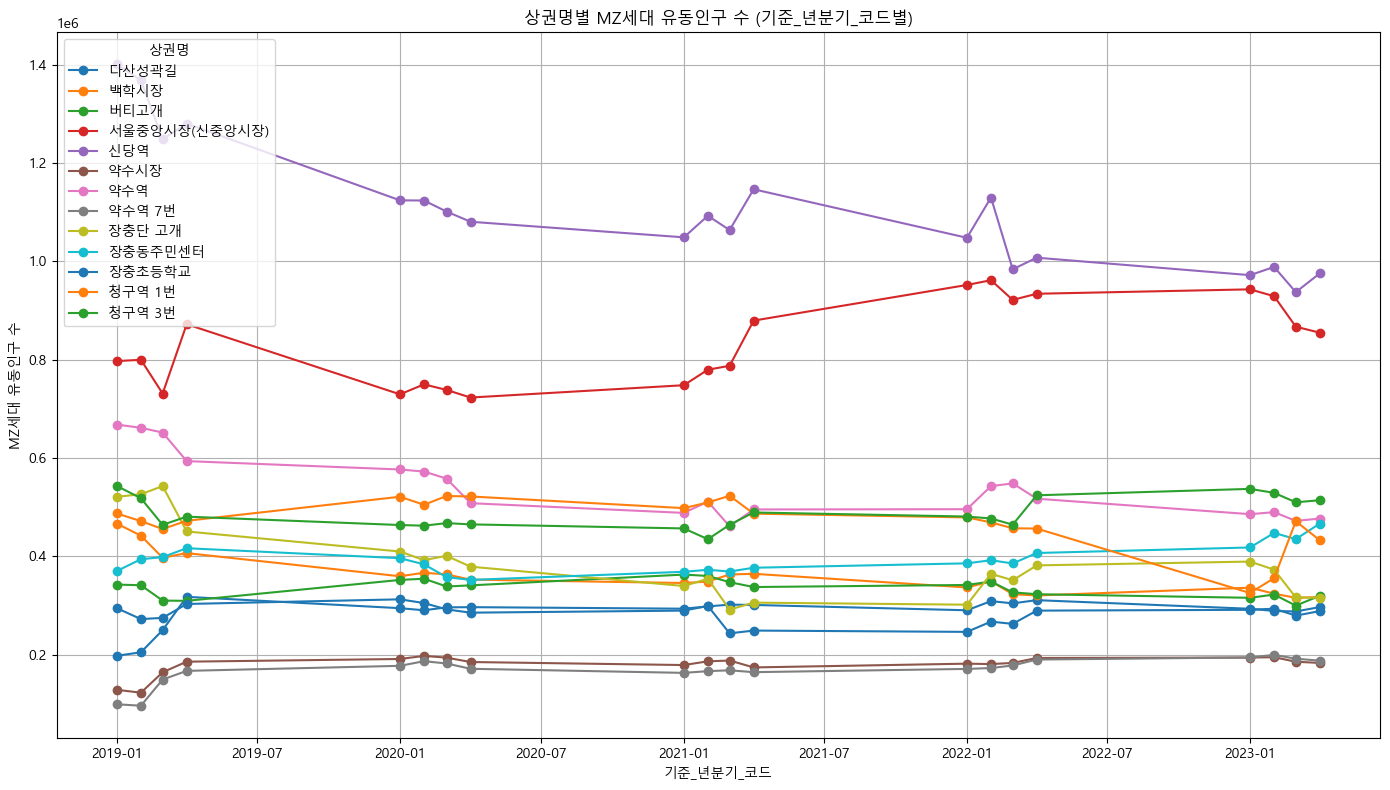

In [63]:
# 기준_년분기_코드를 datetime 형식으로 변환
df['기준_년분기_코드'] = pd.to_datetime(df['기준_년분기_코드'], format='%Y%m')

# 시계열 데이터 시각화
plt.figure(figsize=(14, 8))
for name, group in df.groupby('상권_코드_명'):
    plt.plot(group['기준_년분기_코드'], group['MZ세대_유동인구_수'], marker='o', label=name)

plt.title('상권명별 MZ세대 유동인구 수 (기준_년분기_코드별)')
plt.xlabel('기준_년분기_코드')
plt.ylabel('MZ세대 유동인구 수')
plt.legend(title='상권명')
plt.grid(True)
plt.tight_layout()

plt.show()

### 선형 회귀 분석을 통한 상권별 증가 추세 확인

In [123]:
# 날짜를 숫자로 변환하는 함수
def date_to_numeric(dates):
    return dates.astype(int) / 10**9  # 날짜를 초 단위로 변환하여 숫자로 표현

# 상권명별 추세 검정
results = []
for name, group in df.groupby('상권_코드_명'):
    numeric_dates = date_to_numeric(group['기준_년분기_코드'].values.astype('datetime64[D]'))
    slope, intercept, r_value, p_value, std_err = linregress(numeric_dates, group['MZ세대_유동인구_수'])
    results.append({
        '상권_코드_명': name,
        'slope': slope,
        'p_value': p_value,
        'r_value': r_value,
        'increasing': slope > 0 and p_value < 0.05  # 기울기가 양수이고 p-value가 0.05 미만인 경우 증가 추세로 판단
    })

results_df = pd.DataFrame(results)

results_df

,상권_코드_명,slope,p_value,r_value,increasing
0,다산성곽길,1.132281e+12,1.971868e-02,0.516508,True
1,백학시장,-2.402238e+12,1.111086e-06,-0.860814,False
2,버티고개,-3.856768e+11,1.791171e-01,-0.312950,False
3,서울중앙시장(신중앙시장),4.029016e+12,8.429645e-04,0.685842,True
4,신당역,-7.807218e+12,4.371174e-07,-0.875284,False
5,약수시장,7.285435e+11,1.671806e-02,0.527987,True
6,약수역,-3.564204e+12,1.716101e-05,-0.806919,False
7,약수역 7번,1.321332e+12,5.378768e-04,0.703551,True
8,장충단 고개,-3.728212e+12,2.541556e-04,-0.730558,False
9,장충동주민센터,1.158524e+12,9.659316e-03,0.563576,True


### prophet 사용

C:\Users\Puser\AppData\Local\Temp\ipykernel_4488\1857775712.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['기준_년분기_코드'] = pd.to_datetime(df['기준_년분기_코드'], format='%Y%m')
10:35:32 - cmdstanpy - INFO - Chain [1] start processing
10:35:32 - cmdstanpy - INFO - Chain [1] done processing


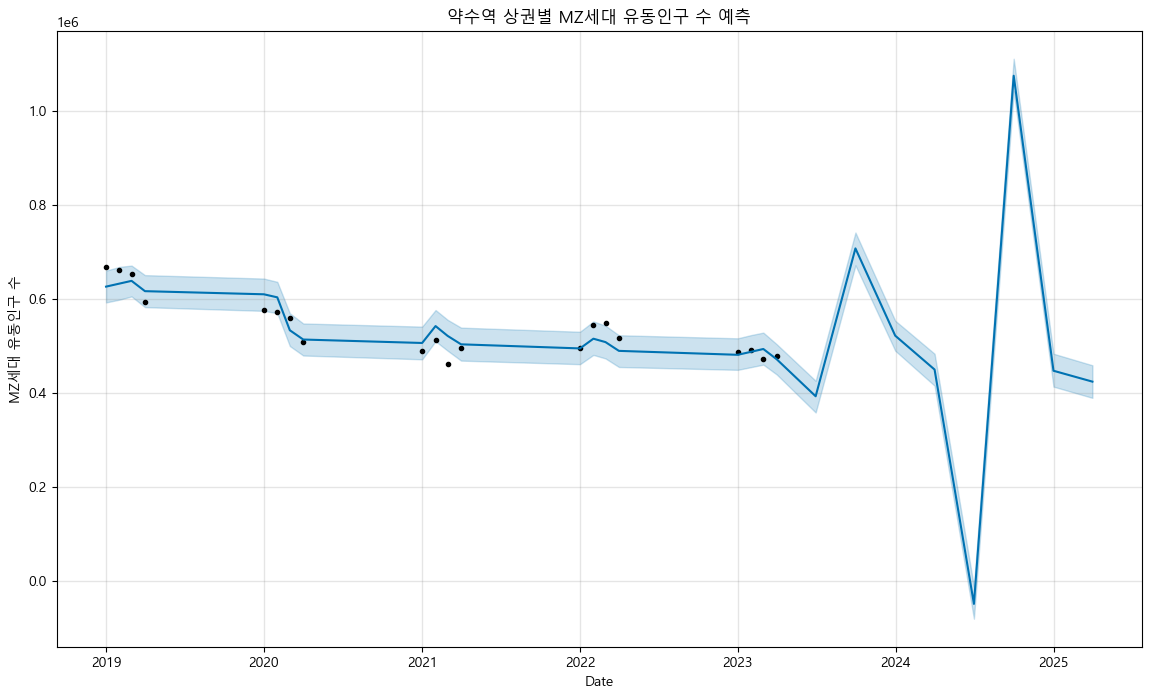

In [21]:
from prophet import Prophet

# 기준_년분기_코드를 datetime 형식으로 변환
df['기준_년분기_코드'] = pd.to_datetime(df['기준_년분기_코드'], format='%Y%m')

# Prophet 모델을 사용하기 위해 데이터프레임 형식 변경
data = df.groupby(['기준_년분기_코드', '상권_코드_명'])['MZ세대_유동인구_수'].sum().reset_index()
data = data.rename(columns={'기준_년분기_코드': 'ds', 'MZ세대_유동인구_수': 'y'})

# 특정 상권 (예: 약수역)의 데이터를 필터링
selected_area = '약수역'
area_data = data[data['상권_코드_명'] == selected_area]

# Prophet 모델 생성 및 학습
model = Prophet()
model.fit(area_data)

# 미래 데이터프레임 생성
future = model.make_future_dataframe(periods=8, freq='Q')  # 2년 (8분기) 예측
forecast = model.predict(future)

# 결과 시각화
fig, ax = plt.subplots(figsize=(14, 8))
model.plot(forecast, ax=ax)
plt.title(f'{selected_area} 상권별 MZ세대 유동인구 수 예측')
plt.xlabel('Date')
plt.ylabel('MZ세대 유동인구 수')
plt.show()


## 상권별 매출 데이터

In [56]:
df1 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(추정매출-상권)_2019년.csv', encoding='cp949')
df2 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(추정매출-상권)_2020년.csv', encoding='cp949')
df3 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(추정매출-상권)_2021년.csv', encoding='cp949')
df4 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(추정매출-상권)_2022년.csv', encoding='cp949')
df5 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(추정매출-상권)_2023년.csv', encoding='cp949')

In [57]:
d1 = pd.concat([df1, df2], axis=0)
d2 = pd.concat([d1, df3], axis=0)
d3 = pd.concat([d2, df4], axis=0)
d4 = pd.concat([d3, df5], axis=0)

In [58]:
# 핀이 있는 상권 영역에 해당하는 데이터만 필터링
data = d4[d4['상권_코드_명'].isin(filter_list)]
data

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
92,20191,D,발달상권,3120038,약수역,CS300001,슈퍼마켓,424867131,32791,293112671,...,14023,5745,14870,16905,240,5555,7169,6847,7363,4602
344,20191,R,전통시장,3130042,약수시장,CS300018,의약품,291670713,27910,252193239,...,5343,0,12791,15119,119,3210,5170,8512,5043,5856
455,20191,A,골목상권,3110053,청구역 1번,CS300024,운동/경기용품,11323374,350,7471886,...,70,0,210,140,0,70,0,210,70,0
595,20191,R,전통시장,3130042,약수시장,CS100001,한식음식점,1133054670,32413,769900652,...,15236,6964,17360,12934,460,5659,6492,7707,5826,4150
753,20191,R,전통시장,3130053,백학시장,CS100006,패스트푸드점,284833981,31411,197921724,...,11351,3612,14967,15694,929,9009,6302,5640,4607,4175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80928,20234,R,전통시장,3130053,백학시장,CS300018,의약품,2351070356,153212,1986736992,...,34135,1811,70333,82801,602,9854,17308,23106,39639,62625
80929,20234,R,전통시장,3130053,백학시장,CS300022,화장품,22195074,883,15040630,...,221,0,270,613,0,17,11,34,199,622
80930,20234,R,전통시장,3130053,백학시장,CS300024,운동/경기용품,466043121,3126,329265486,...,944,9,611,2507,0,43,70,131,1231,1643
80931,20234,R,전통시장,3130053,백학시장,CS300027,섬유제품,6506104,117,4151593,...,59,8,74,43,0,0,8,16,67,26


### 상권 전체 월 매출 금액 추이

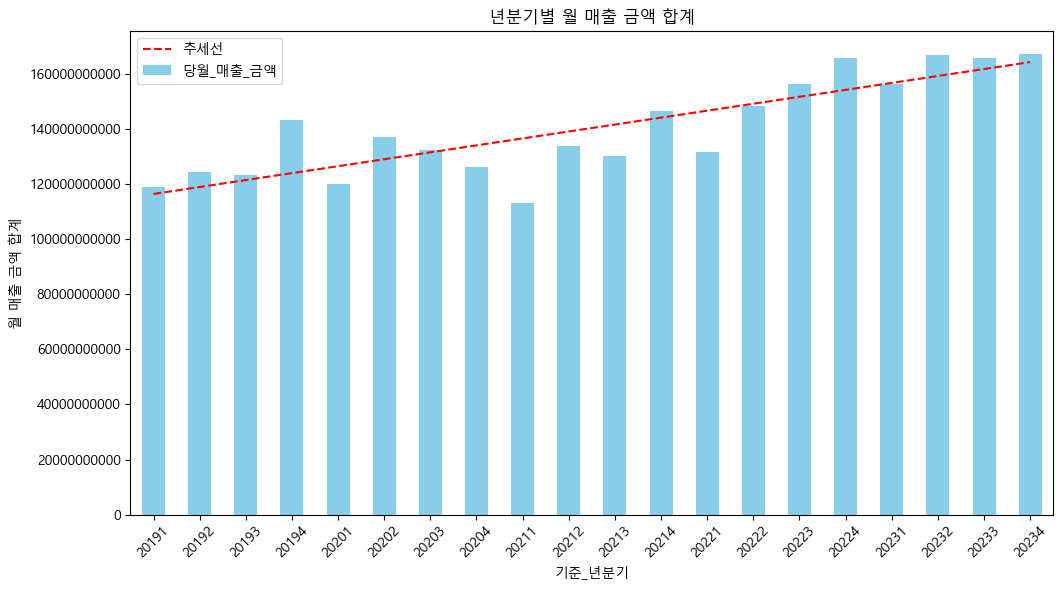

In [59]:
# 기준_년분기_코드별 당월_매출_금액 합계 계산
sales_sum = data.groupby('기준_년분기_코드')['당월_매출_금액'].sum()

# 그래프 시각화
plt.figure(figsize=(10, 6))
sales_sum.plot(kind='bar', color='skyblue')

# 추세선 추가
x = np.arange(len(sales_sum))
y = sales_sum.values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='추세선')

plt.title('년분기별 월 매출 금액 합계')
plt.xlabel('기준_년분기')
plt.ylabel('월 매출 금액 합계')
plt.xticks(rotation=45)
plt.tight_layout()

# Y축을 정수 형식으로 설정
y_formatter = ScalarFormatter(useOffset=False)
y_formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(y_formatter)

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

### 상권별 월 매출 추이

In [131]:
# 상권_코드_명, 기준_년분기_코드별로 당월_매출_금액의 합계 계산
sales_sum = data.groupby(['상권_코드_명', '기준_년분기_코드'])['당월_매출_금액'].sum().reset_index()
sales_sum

,상권_코드_명,기준_년분기_코드,당월_매출_금액
0,다산성곽길,20204,121803138
1,다산성곽길,20224,704534994
2,다산성곽길,20232,299379292
3,다산성곽길,20233,51285532
4,다산성곽길,20234,534651669
...,...,...,...
233,청구역 3번,20224,10189914786
234,청구역 3번,20231,8505224546
235,청구역 3번,20232,7692496499
236,청구역 3번,20233,11877607188


LinAlgError: 추세선 계산 실패 (다산성곽길)


C:\Users\Puser\AppData\Local\Temp\ipykernel_4488\2508188656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['기준_년분기_코드'] = data['기준_년분기_코드'].astype(str)


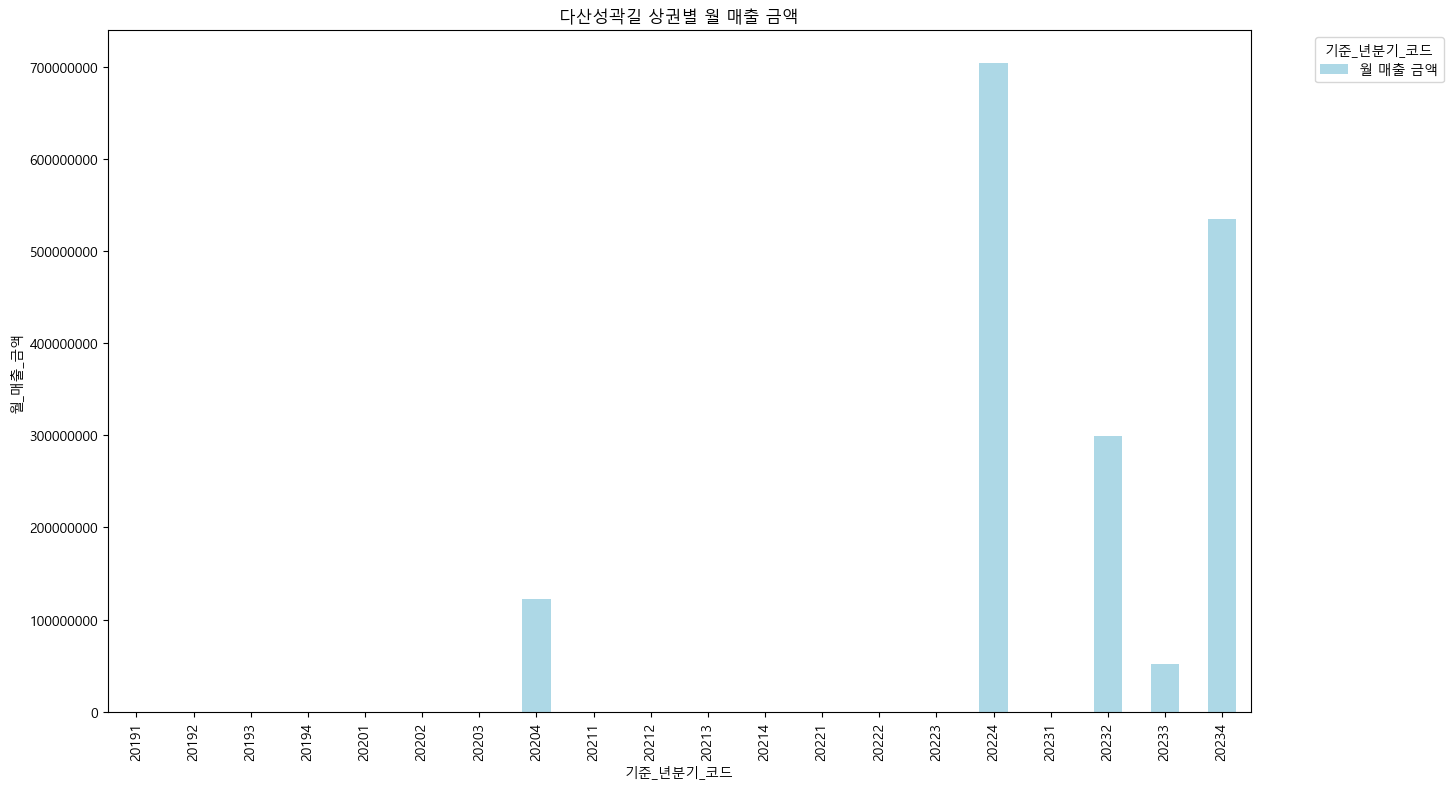

백학시장: 추세가 증가하는 경향을 보입니다.


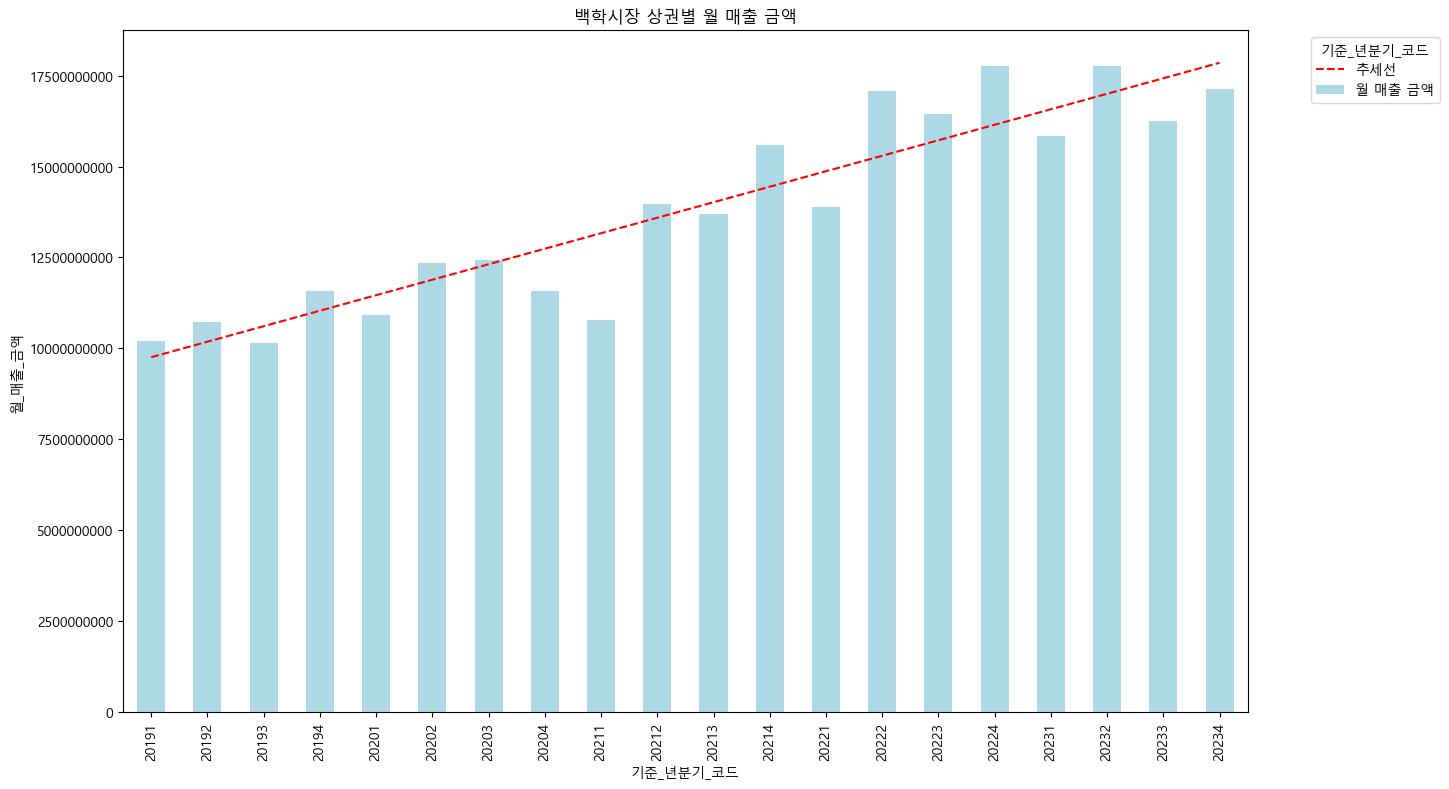

LinAlgError: 추세선 계산 실패 (버티고개)


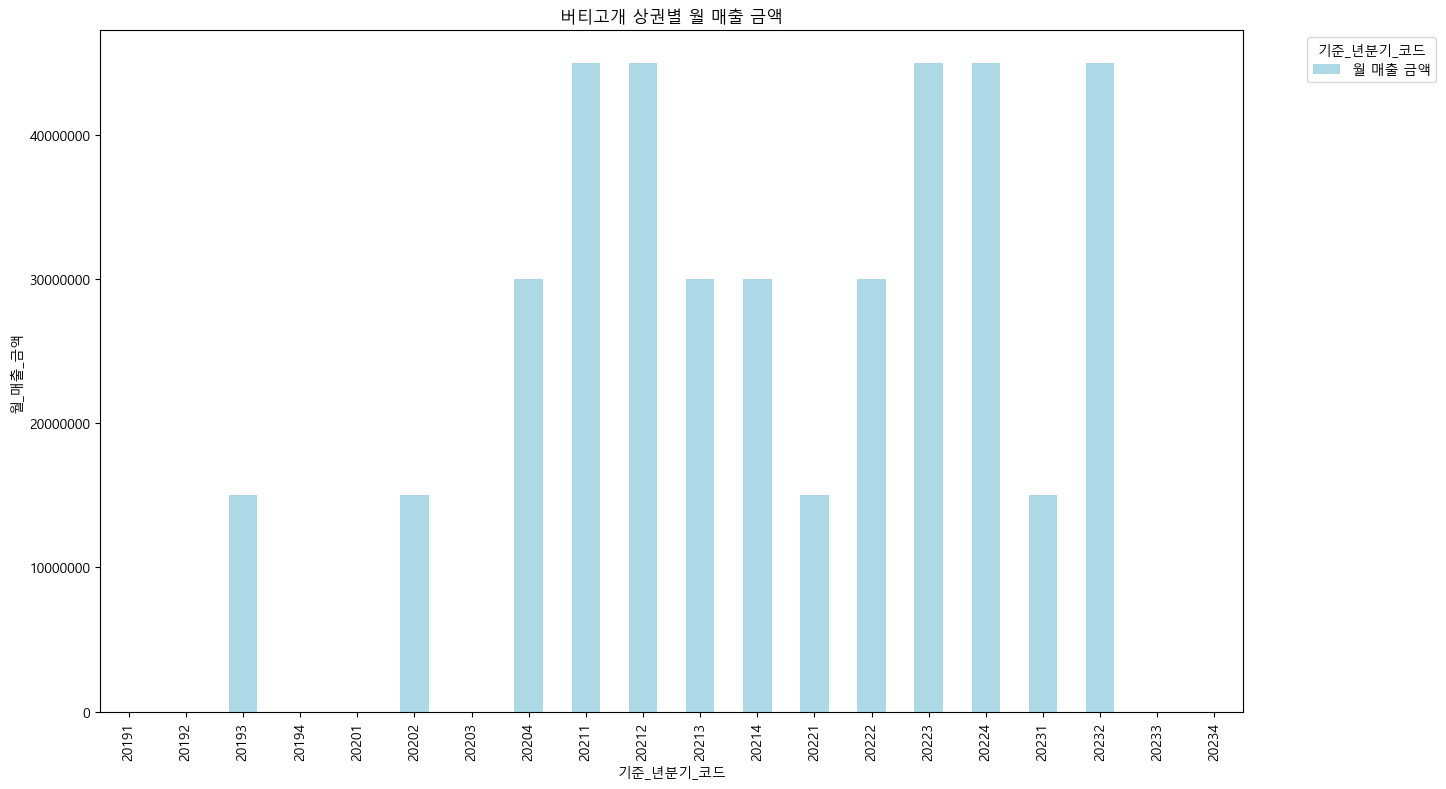

서울중앙시장(신중앙시장): 추세가 증가하는 경향을 보입니다.


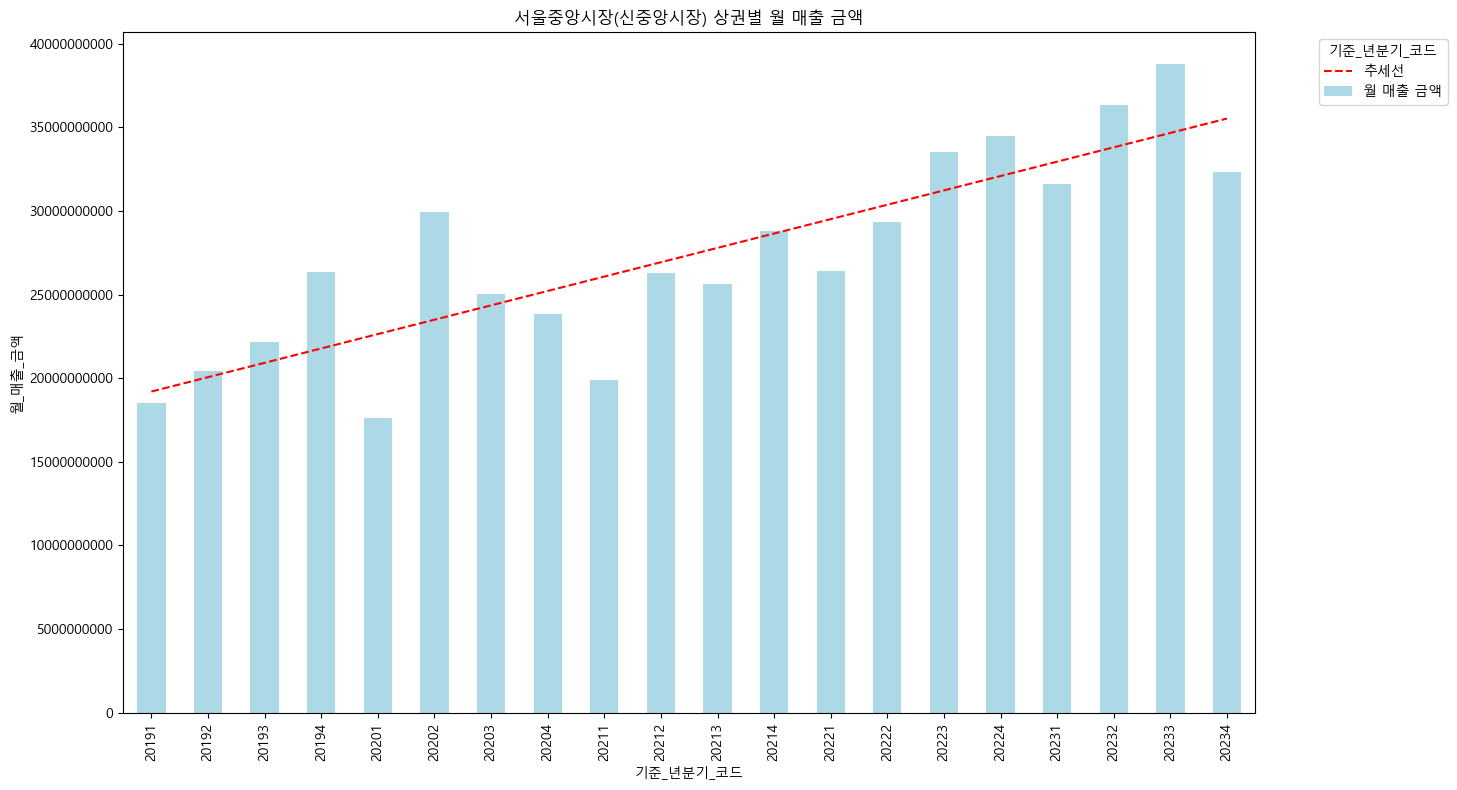

신당역: 추세가 증가하는 경향을 보입니다.


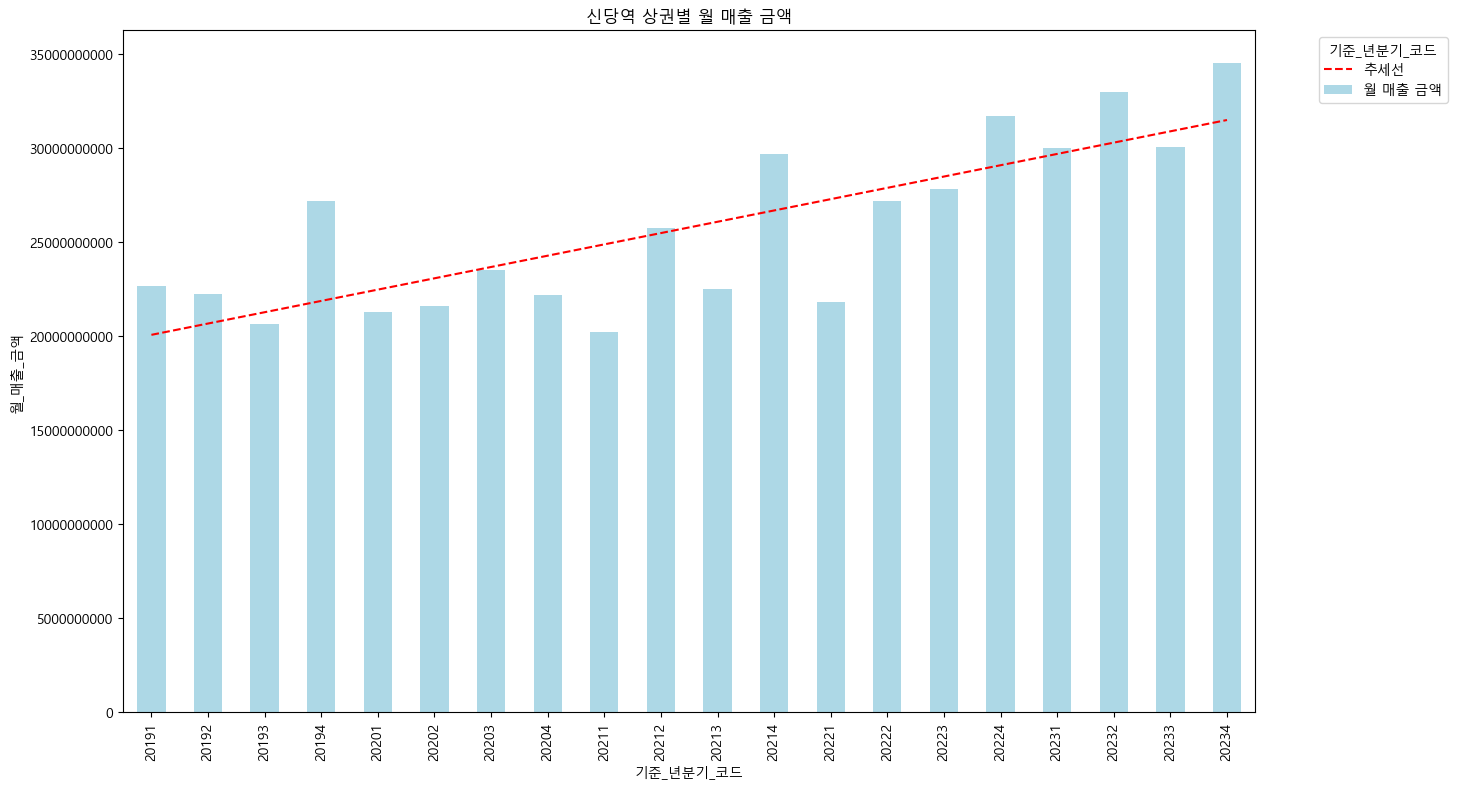

약수시장: 추세가 감소하는 경향을 보입니다.


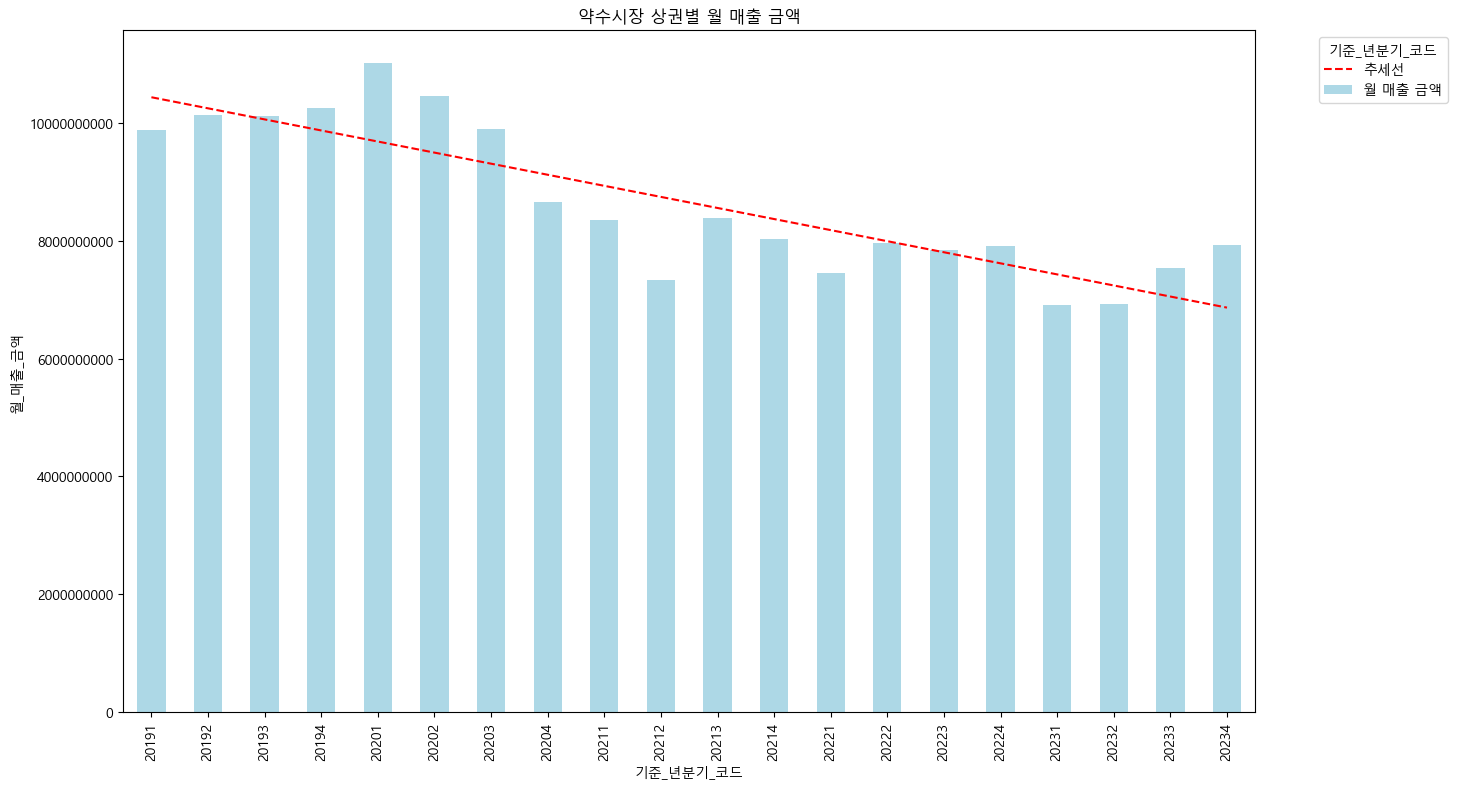

약수역: 추세가 증가하는 경향을 보입니다.


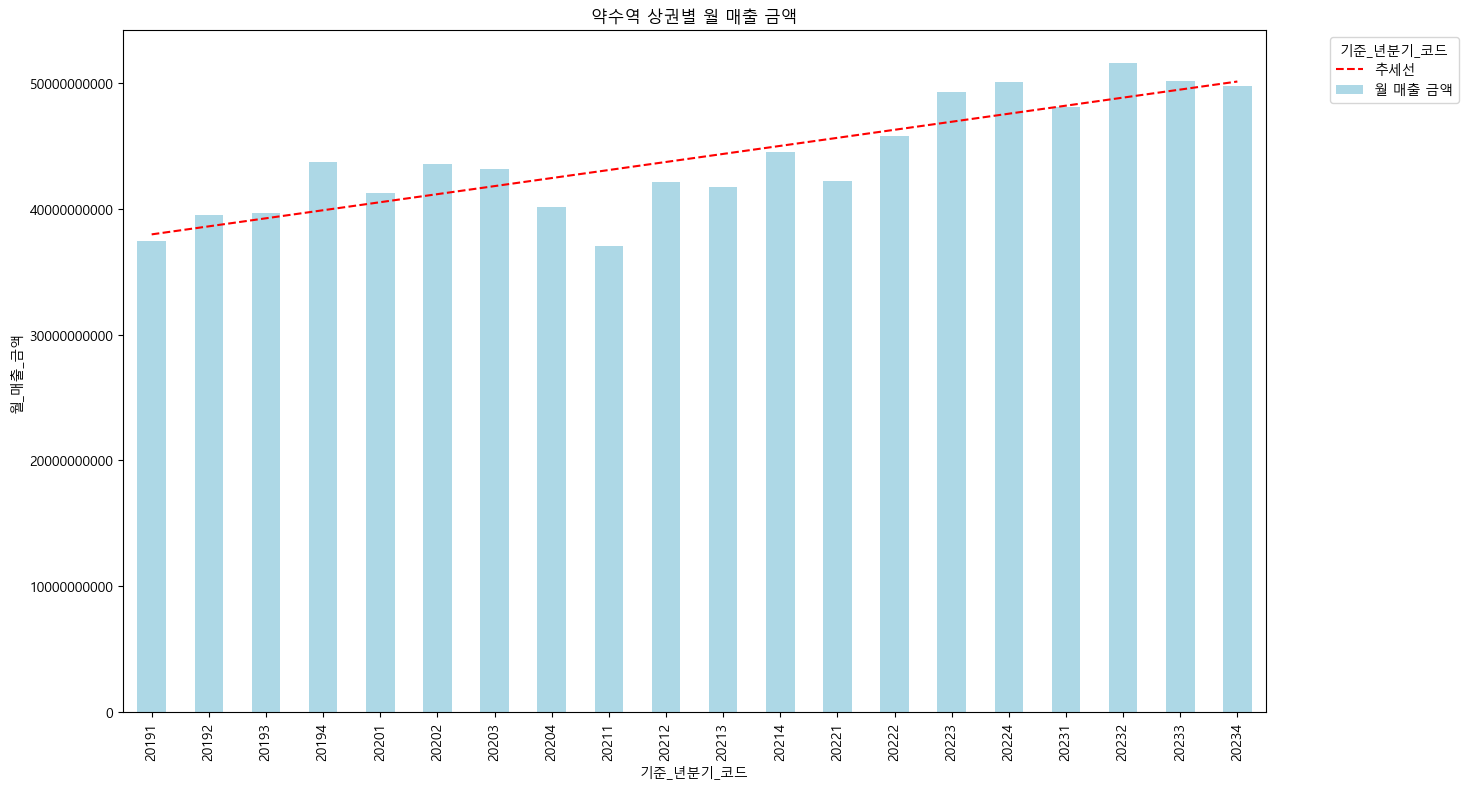

약수역 7번: 추세가 증가하는 경향을 보입니다.


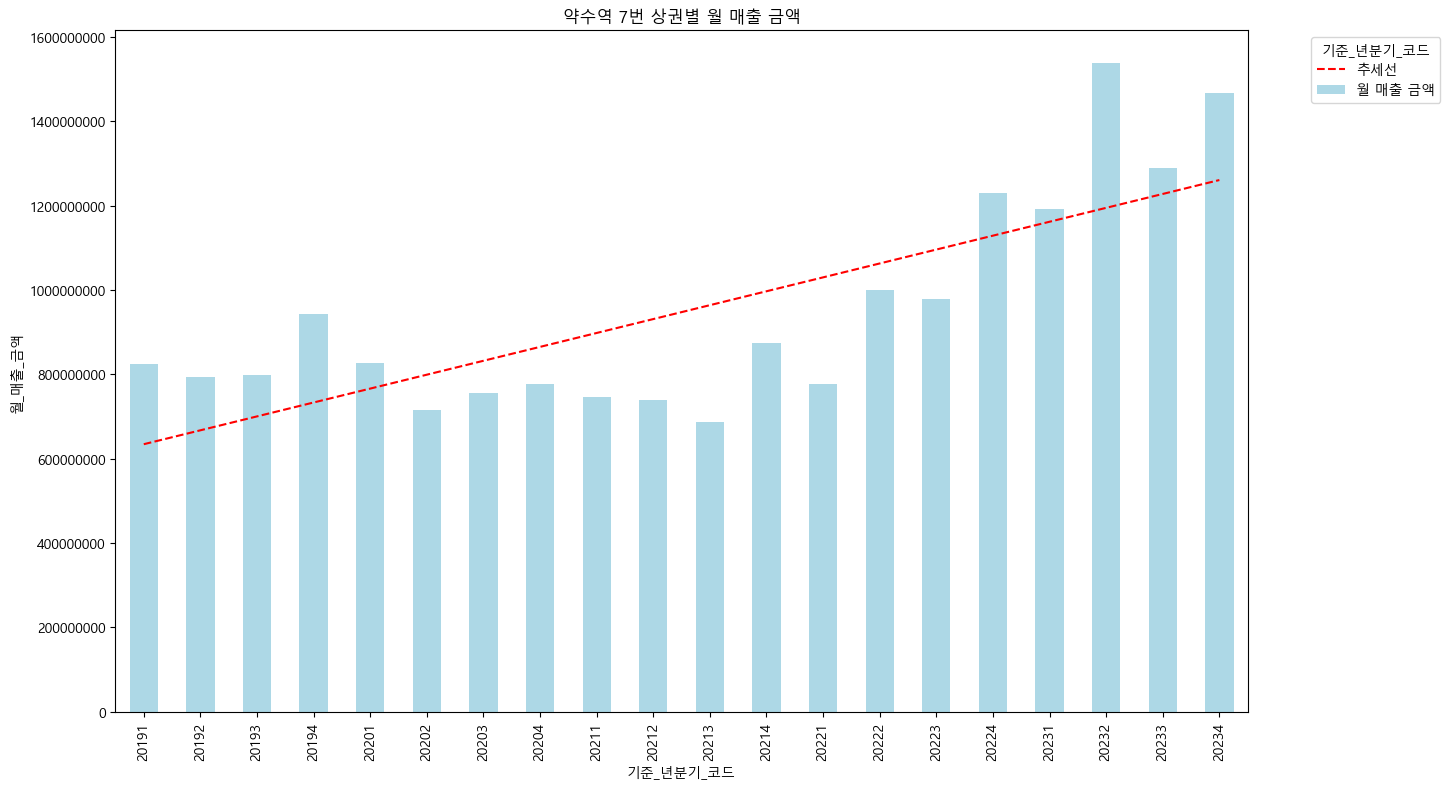

장충단 고개: 추세가 증가하는 경향을 보입니다.


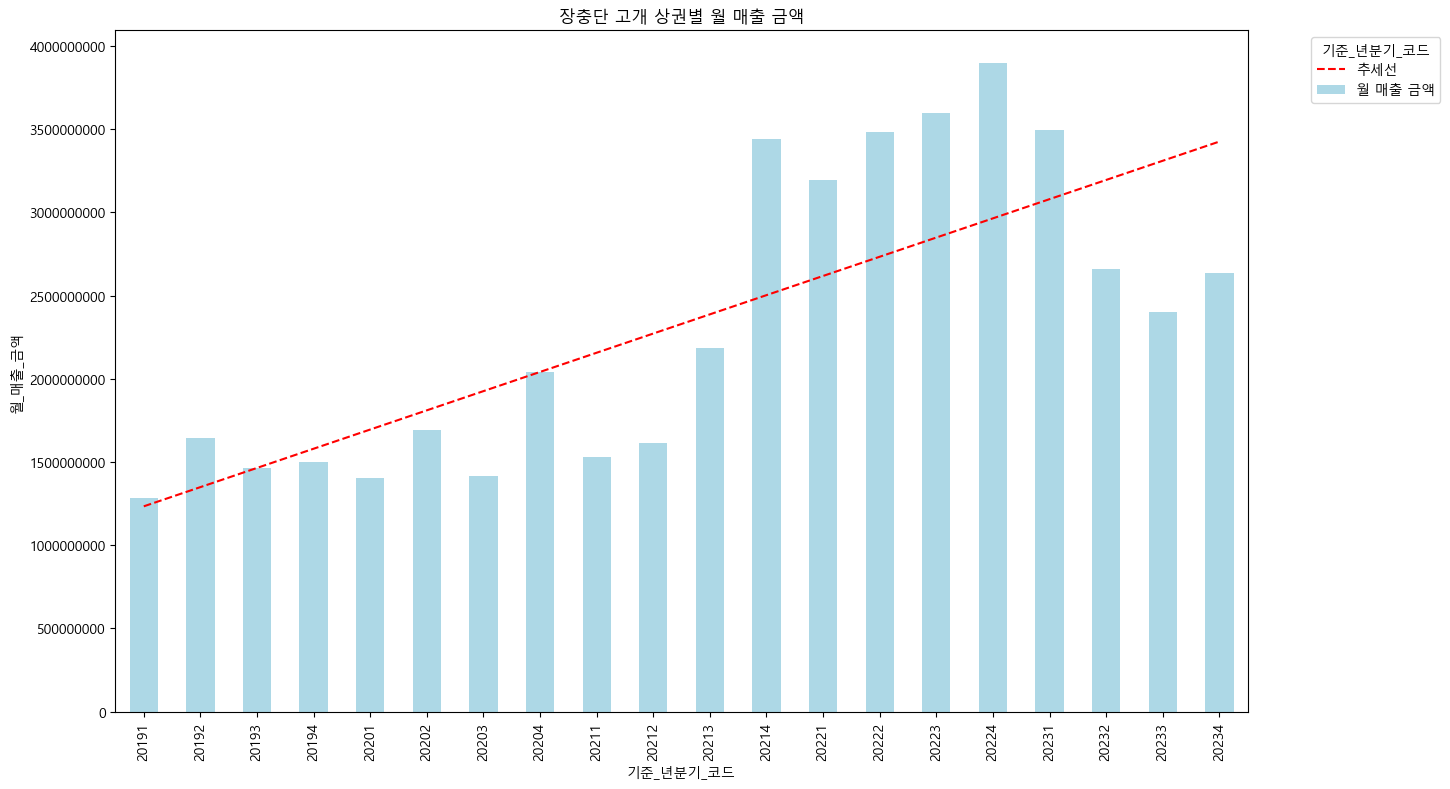

장충동주민센터: 추세가 감소하는 경향을 보입니다.


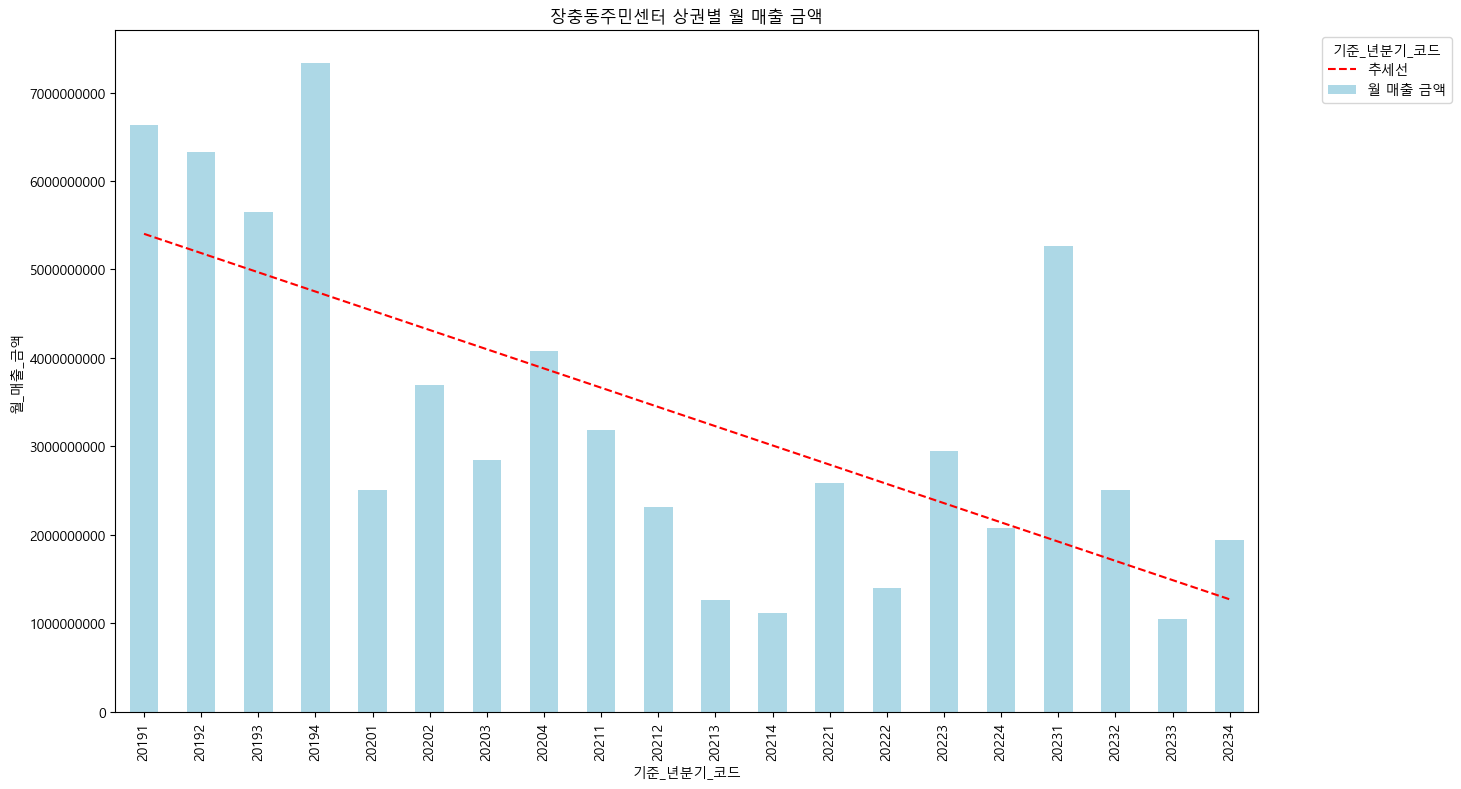

장충초등학교: 추세가 증가하는 경향을 보입니다.


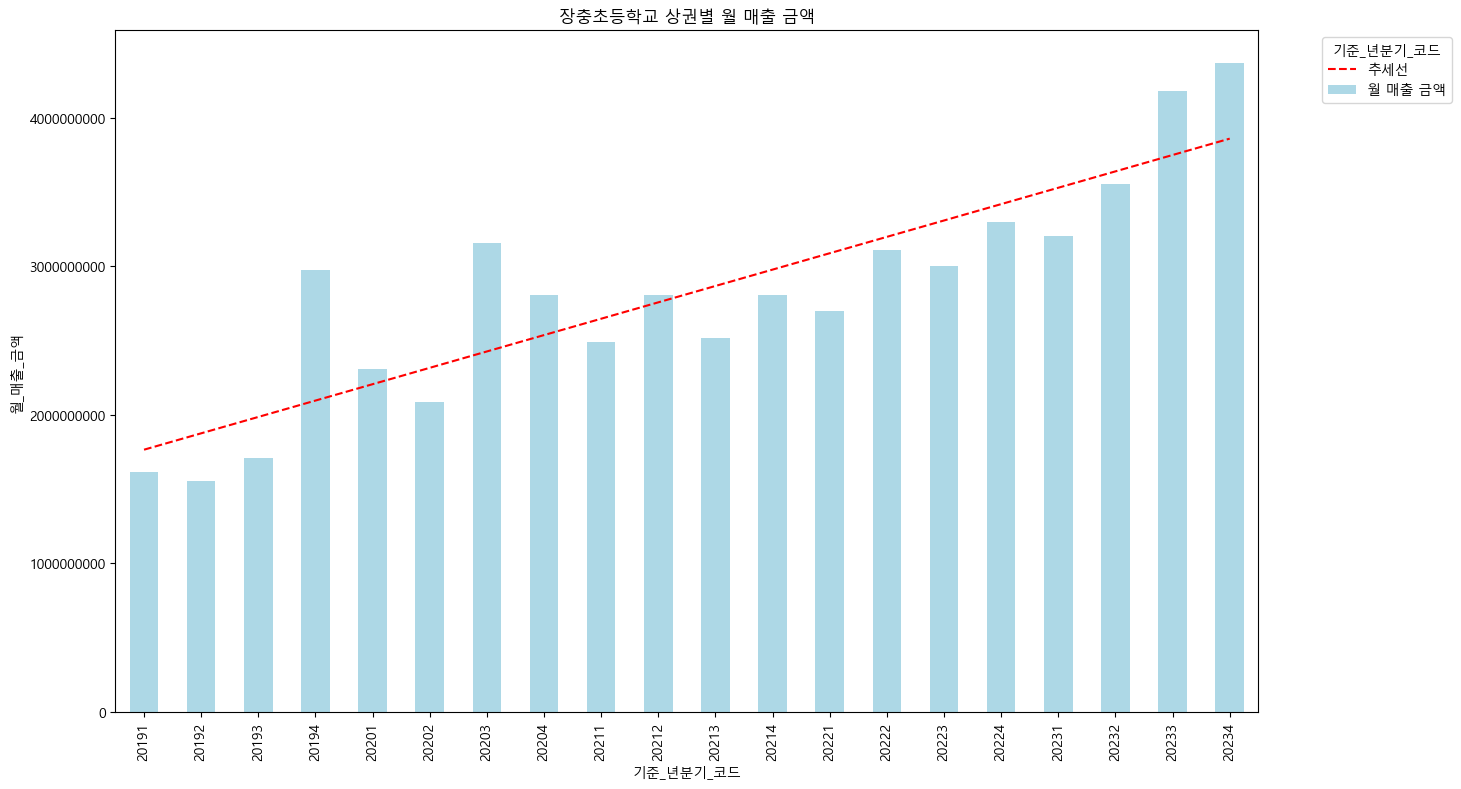

청구역 1번: 추세가 증가하는 경향을 보입니다.


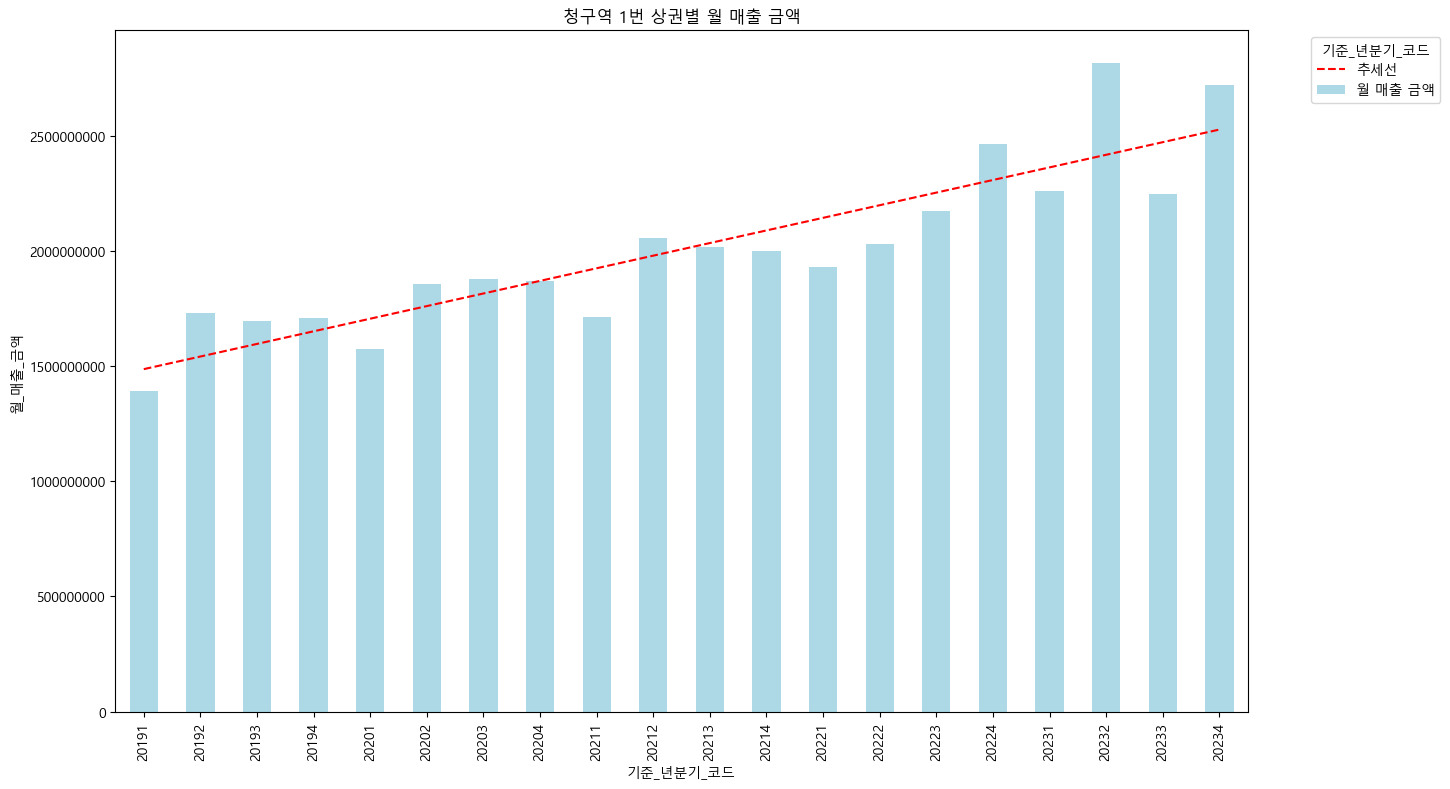

청구역 3번: 추세가 증가하는 경향을 보입니다.


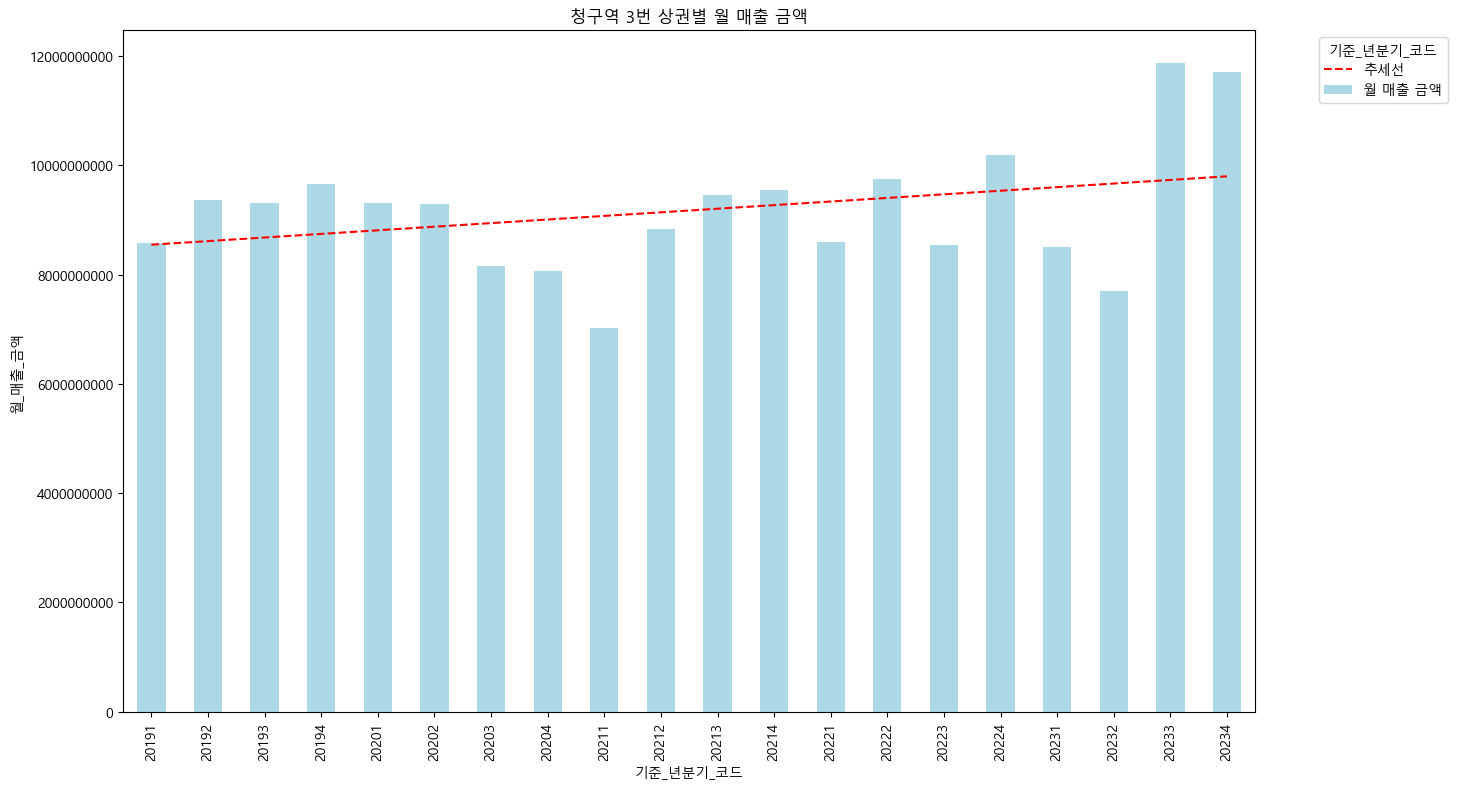

In [27]:
# 기준_년분기_코드를 문자열로 변환
data['기준_년분기_코드'] = data['기준_년분기_코드'].astype(str)

# 상권_코드_명별, 기준_년분기_코드별 당월_매출_금액 합계 계산
sales_sum = data.groupby(['상권_코드_명', '기준_년분기_코드'])['당월_매출_금액'].sum().unstack()

# 상권_코드_명별로 개별 그래프 생성
for name, group in sales_sum.iterrows():
    plt.figure(figsize=(14, 8))
    group.plot(kind='bar', color='lightblue', label='월 매출 금액')

    # 추세선 추가 (예외 처리 포함)
    try:
        x = np.arange(len(group.index))
        y = group.values

        # 데이터 정규화
        x_norm = (x - np.mean(x)) / np.std(x)
        y_norm = (y - np.mean(y)) / np.std(y)

        z = np.polyfit(x_norm, y_norm, 1)
        p = np.poly1d(z)
        plt.plot(group.index, np.polyval(z, x_norm) * np.std(y) + np.mean(y), "r--", label='추세선')

        # 추세가 증가하는지 여부 출력
        if z[0] > 0:
            print(f"{name}: 추세가 증가하는 경향을 보입니다.")
        else:
            print(f"{name}: 추세가 감소하는 경향을 보입니다.")
    except np.linalg.LinAlgError:
        print(f"LinAlgError: 추세선 계산 실패 ({name})")

    plt.title(f'{name} 상권별 월 매출 금액')
    plt.xlabel('기준_년분기_코드')
    plt.ylabel('월_매출_금액')
    plt.legend(title='기준_년분기_코드', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Y축을 정수 형식으로 설정
    y_formatter = ScalarFormatter(useOffset=False)
    y_formatter.set_scientific(False)
    plt.gca().yaxis.set_major_formatter(y_formatter)

    # 그래프 출력
    plt.show()

## 상권별 점포 데이터

In [60]:
df1 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(점포-상권)_2019년.csv', encoding='cp949')
df2 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(점포-상권)_2020년.csv', encoding='cp949')
df3 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(점포-상권)_2021년.csv', encoding='cp949')
df4 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(점포-상권)_2022년.csv', encoding='cp949')
df5 = pd.read_csv('data/상권 관련/약수/서울시_상권분석서비스(점포-상권)_2023년.csv', encoding='cp949')

In [61]:
d1 = pd.concat([df1, df2], axis=0)
d2 = pd.concat([d1, df3], axis=0)
d3 = pd.concat([d2, df4], axis=0)
d4 = pd.concat([d3, df5], axis=0)

In [62]:
# 핀이 있는 상권 영역에 해당하는 데이터만 필터링
data = d4[d4['상권_코드_명'].isin(filter_list)]
data

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,점포_수,유사_업종_점포_수,개업_율,개업_점포_수,폐업_률,폐업_점포_수,프랜차이즈_점포_수
169,20191,D,발달상권,3120039,신당역,CS200021,기타오락장,1,1,0,0,0,0,0
200,20191,A,골목상권,3110052,장충초등학교,CS100003,일식음식점,1,1,0,0,0,0,0
308,20191,A,골목상권,3110054,청구역 3번,CS300035,인테리어,3,3,0,0,0,0,0
310,20191,D,발달상권,3120038,약수역,CS300006,미곡판매,1,1,0,0,0,0,0
311,20191,R,전통시장,3130053,백학시장,CS300033,철물점,2,2,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295018,20234,R,전통시장,3130053,백학시장,CS300033,철물점,1,1,0,0,0,0,0
295019,20234,R,전통시장,3130053,백학시장,CS300035,인테리어,3,3,0,0,0,0,0
295020,20234,R,전통시장,3130053,백학시장,CS300036,조명용품,1,1,0,0,0,0,0
295021,20234,R,전통시장,3130053,백학시장,CS300040,재생용품 판매점,1,1,0,0,0,0,0


### 상권 전체 점포 수 추이

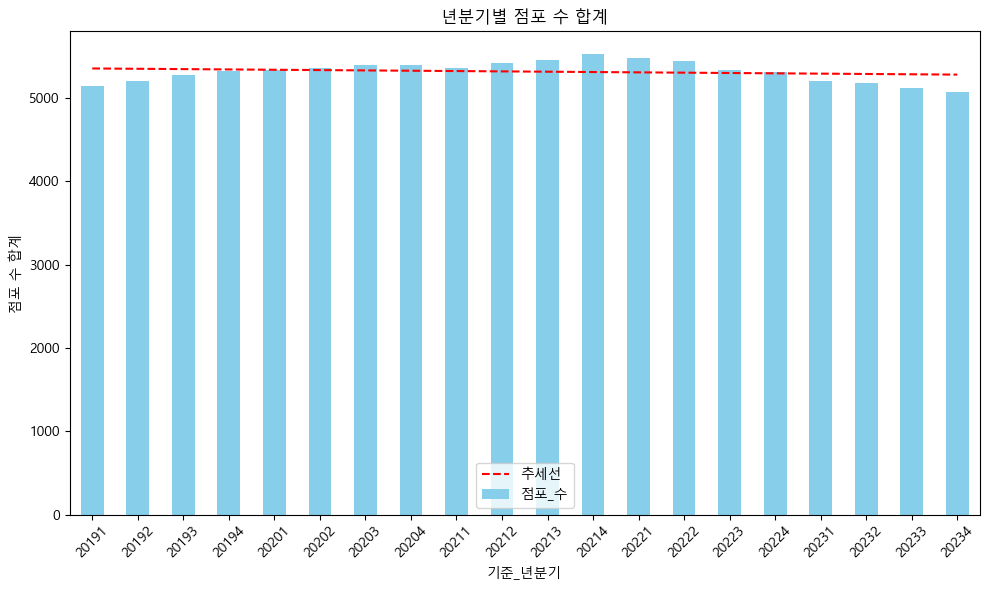

In [63]:
# 기준_년분기_코드별 점포_수 합계 계산
store_sum = data.groupby('기준_년분기_코드')['점포_수'].sum()

# 그래프 시각화
plt.figure(figsize=(10, 6))
store_sum.plot(kind='bar', color='skyblue')

# 추세선 추가
x = np.arange(len(store_sum))
y = store_sum.values
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label='추세선')

plt.title('년분기별 점포 수 합계')
plt.xlabel('기준_년분기')
plt.ylabel('점포 수 합계')
plt.xticks(rotation=45)
plt.tight_layout()

# Y축을 정수 형식으로 설정
y_formatter = ScalarFormatter(useOffset=False)
y_formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(y_formatter)

# 범례 추가
plt.legend()

# 그래프 출력
plt.show()

### 상권별 점포 수 추이

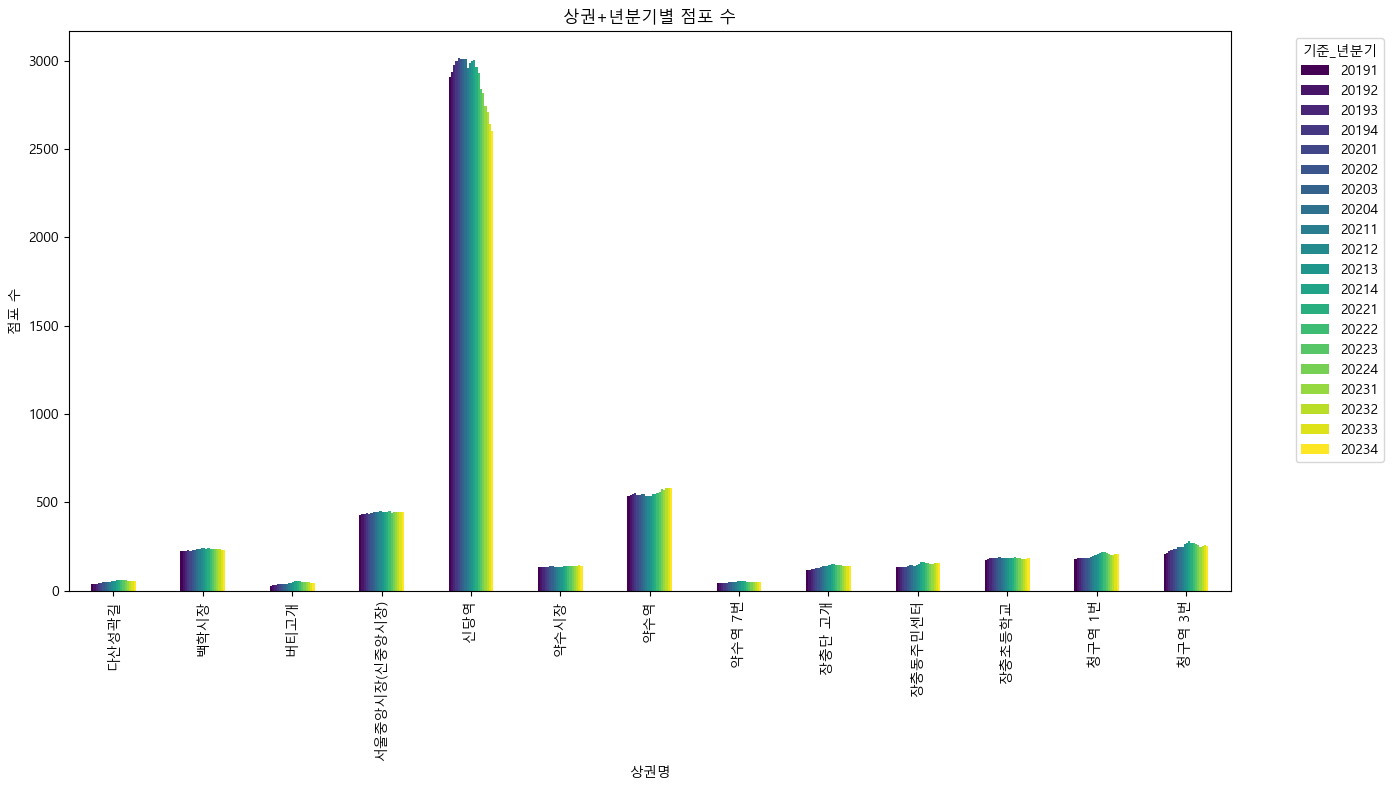

In [151]:
# 상권_코드_명별, 기준_년분기_코드별 점포_수 합계 계산
store_sum = data.groupby(['상권_코드_명', '기준_년분기_코드'])['점포_수'].sum().unstack()

# 그래프 시각화
store_sum.plot(kind='bar', figsize=(14, 8), colormap='viridis')
plt.title('상권+년분기별 점포 수')
plt.xlabel('상권명')
plt.ylabel('점포 수')
plt.legend(title='기준_년분기', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Y축을 정수 형식으로 설정
y_formatter = ScalarFormatter(useOffset=False)
y_formatter.set_scientific(False)
plt.gca().yaxis.set_major_formatter(y_formatter)

# 그래프 출력
plt.show()

다산성곽길: 추세가 증가하는 경향을 보입니다.


C:\Users\Puser\AppData\Local\Temp\ipykernel_4488\558942102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['기준_년분기_코드'] = data['기준_년분기_코드'].astype(str)


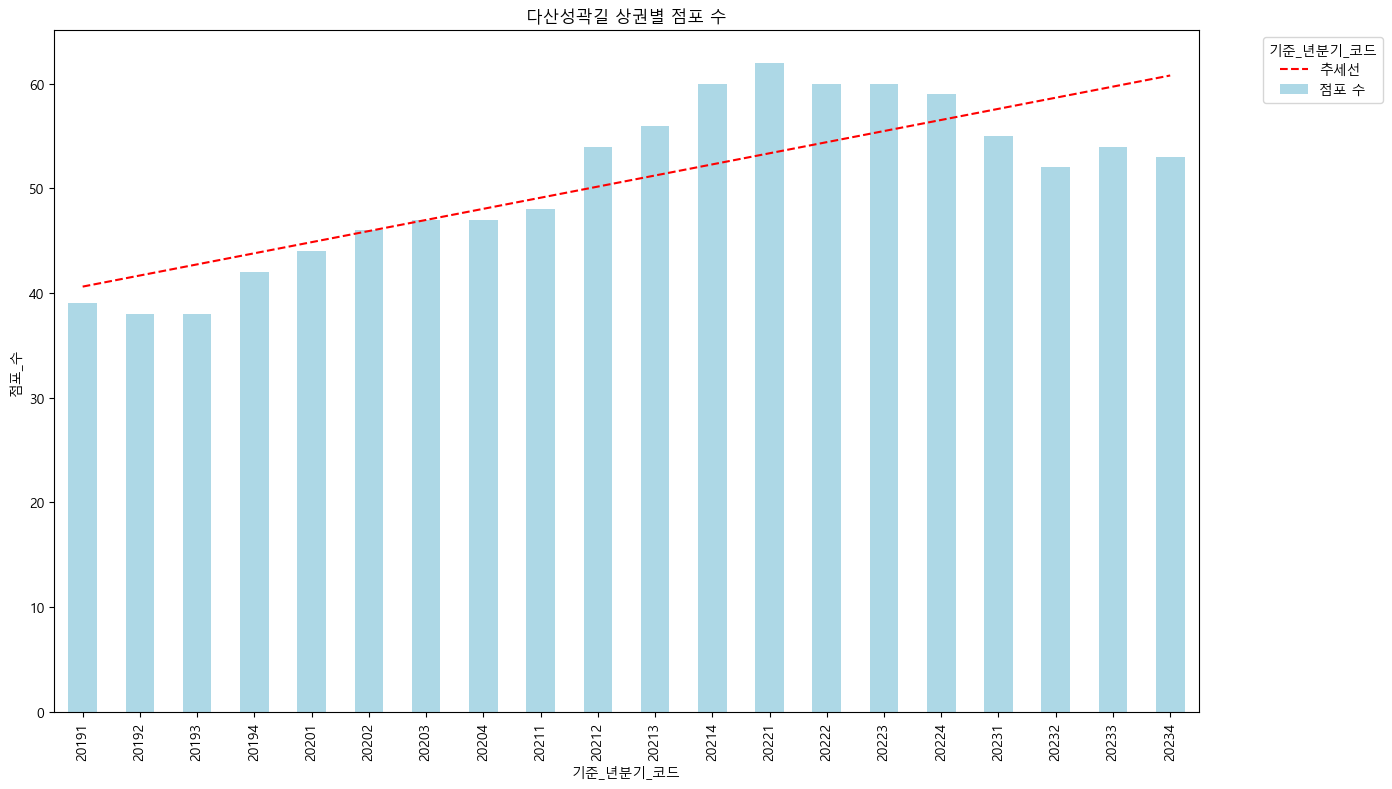

백학시장: 추세가 증가하는 경향을 보입니다.


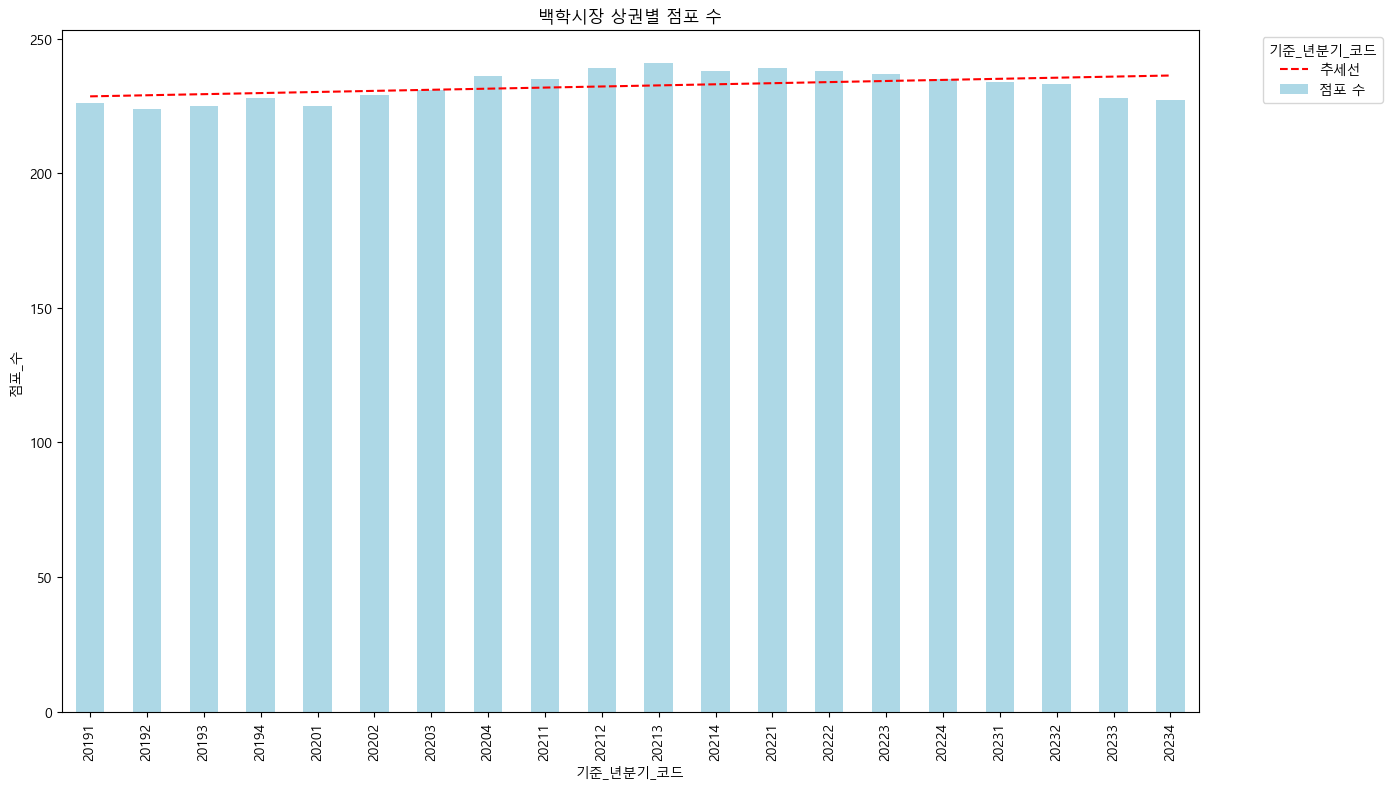

버티고개: 추세가 증가하는 경향을 보입니다.


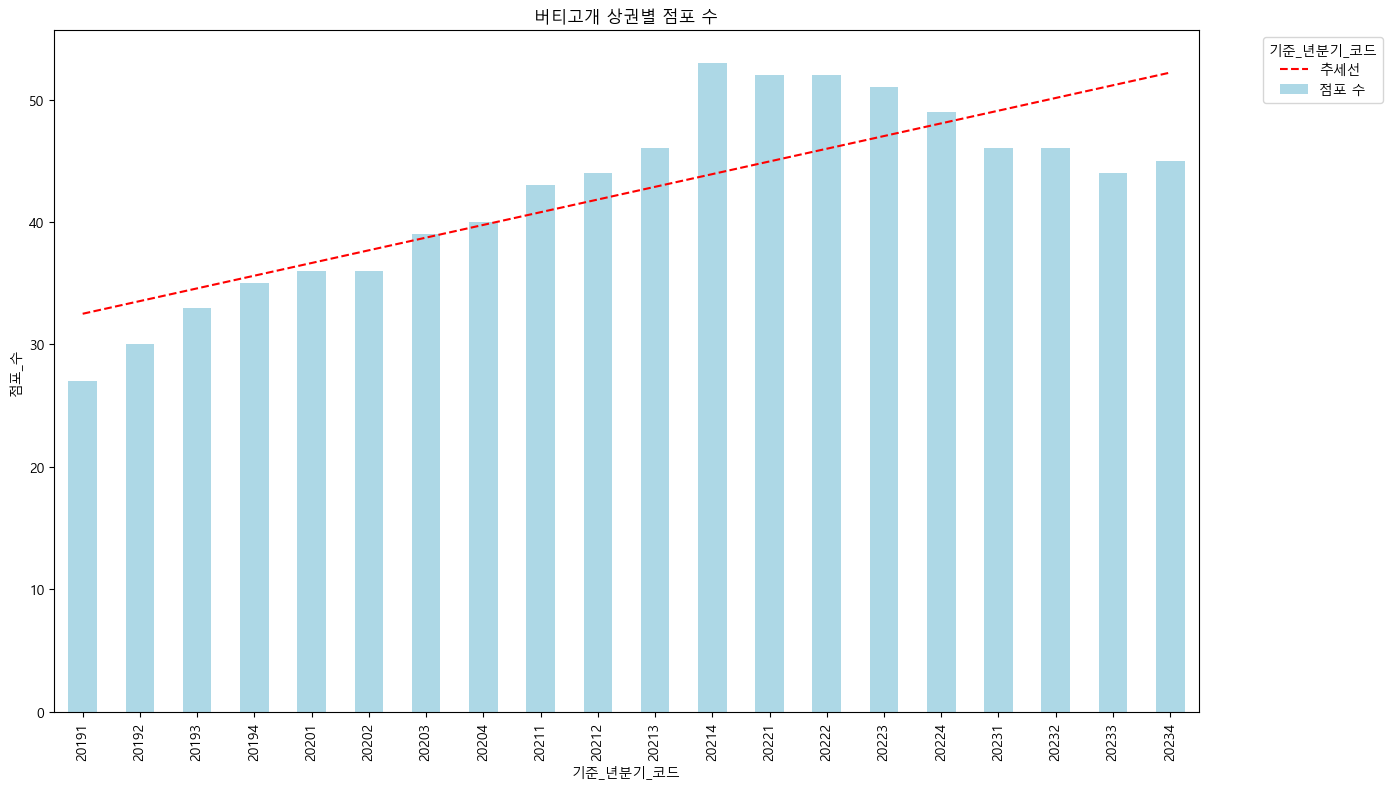

서울중앙시장(신중앙시장): 추세가 증가하는 경향을 보입니다.


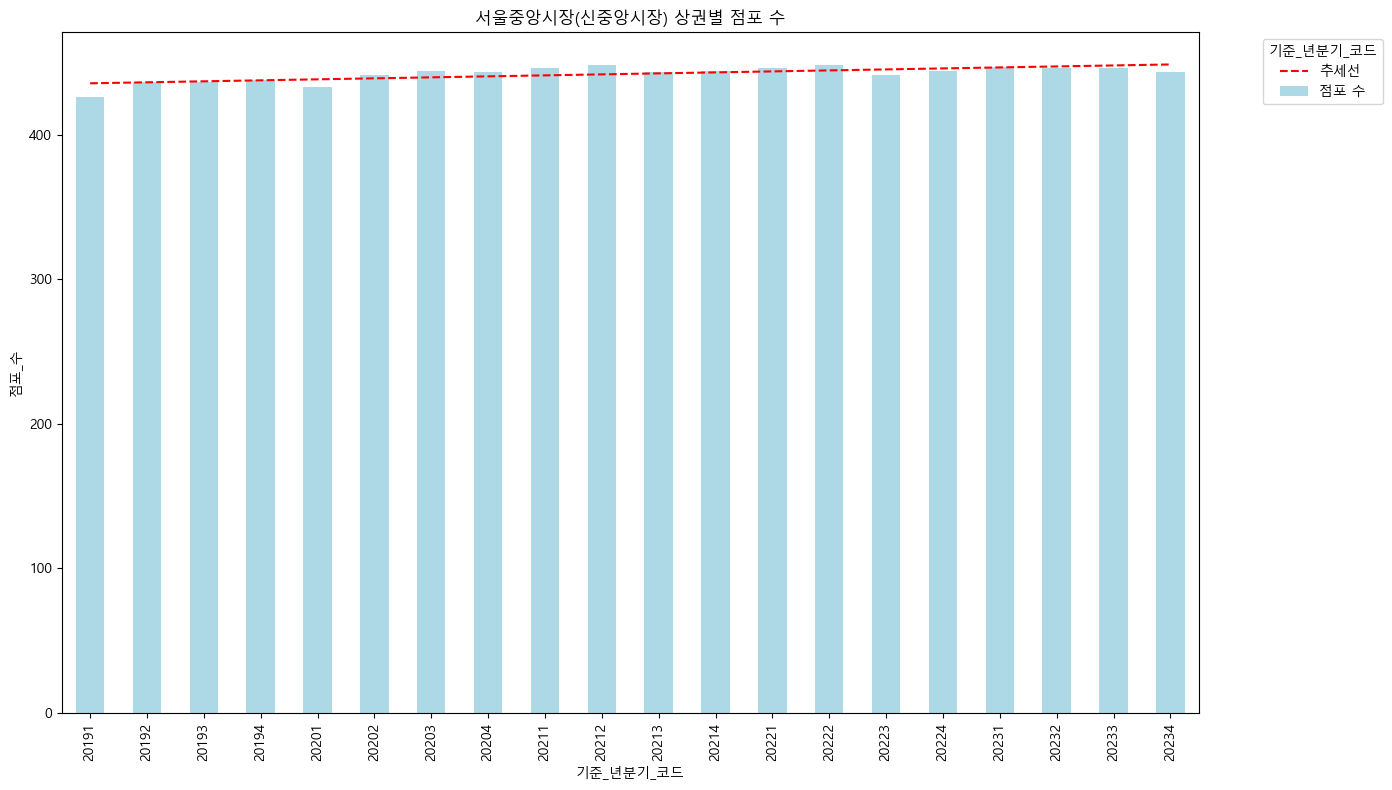

신당역: 추세가 감소하는 경향을 보입니다.


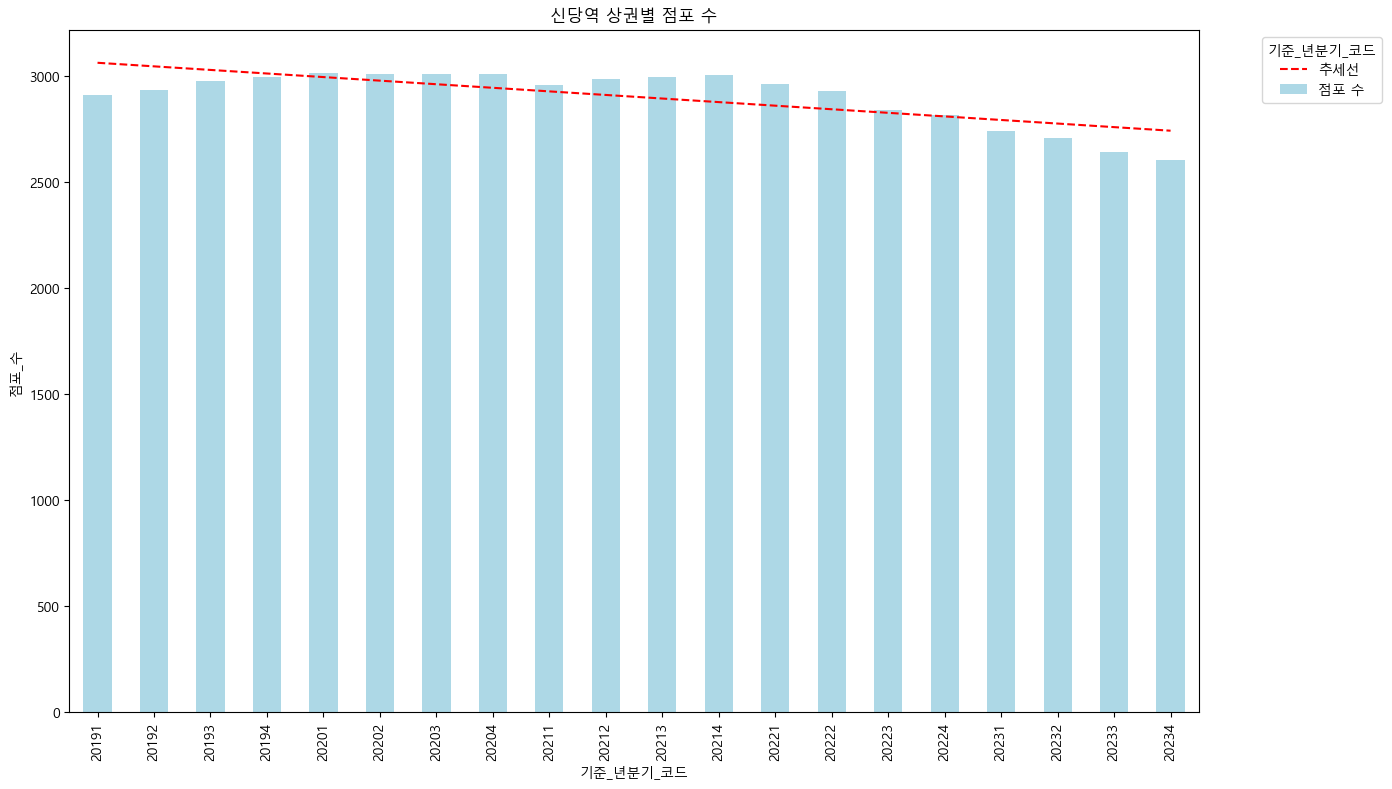

약수시장: 추세가 증가하는 경향을 보입니다.


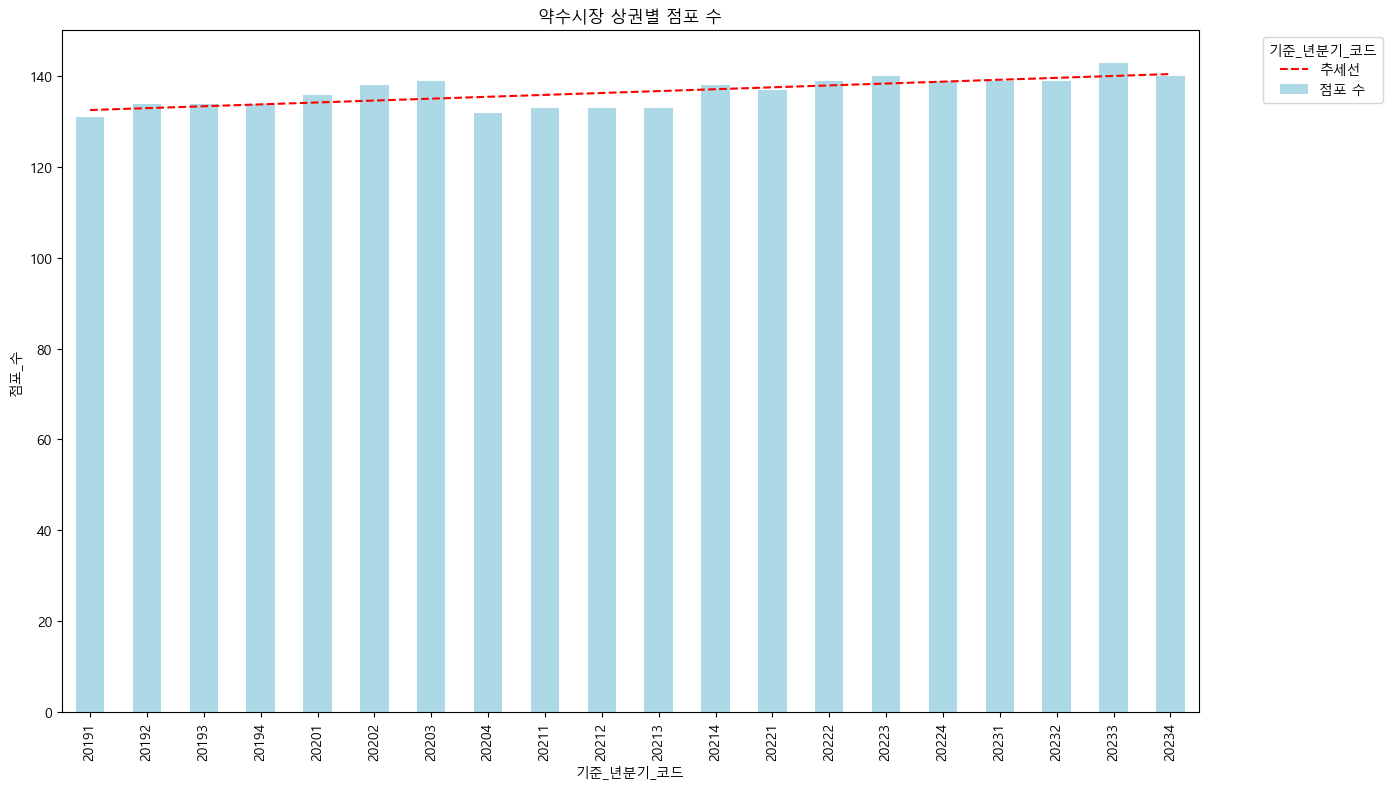

약수역: 추세가 증가하는 경향을 보입니다.


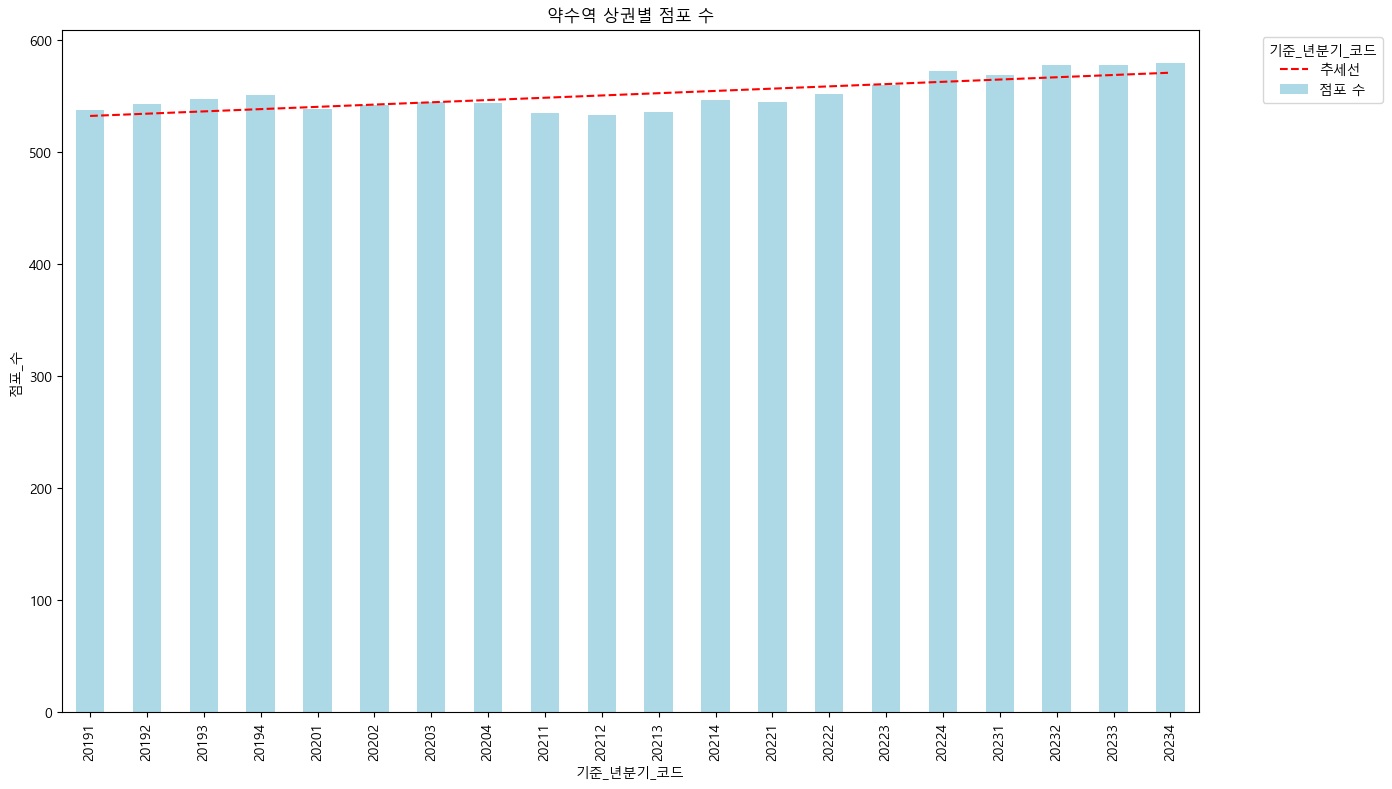

약수역 7번: 추세가 증가하는 경향을 보입니다.


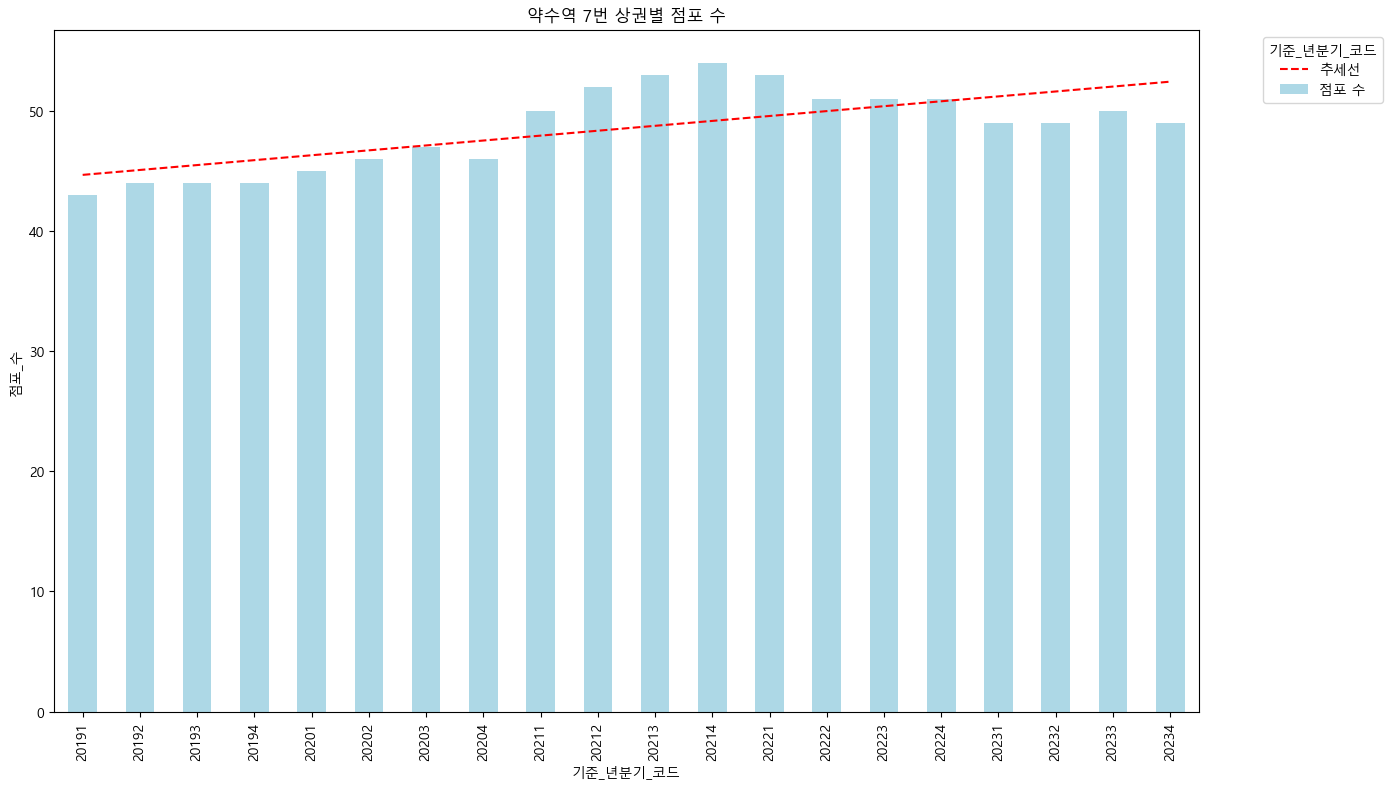

장충단 고개: 추세가 증가하는 경향을 보입니다.


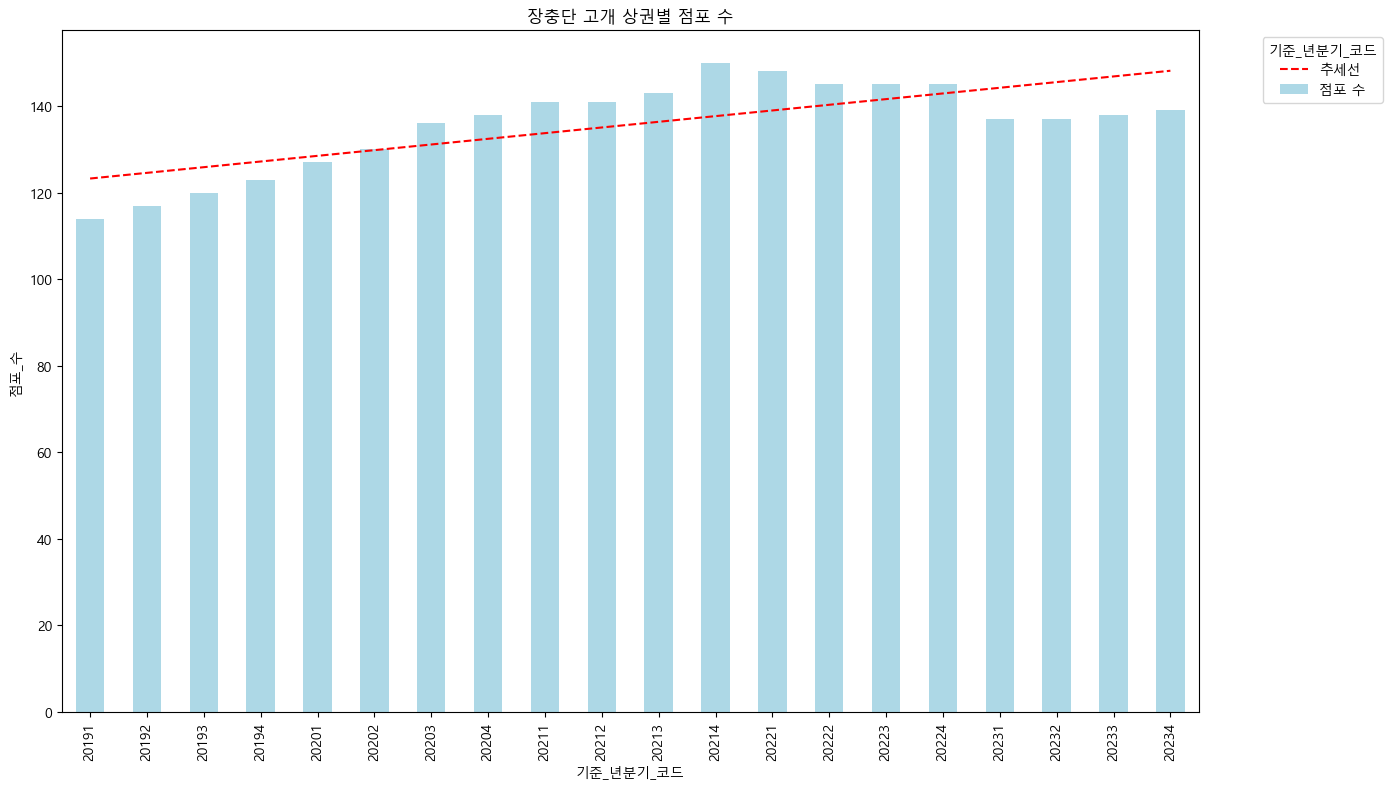

장충동주민센터: 추세가 증가하는 경향을 보입니다.


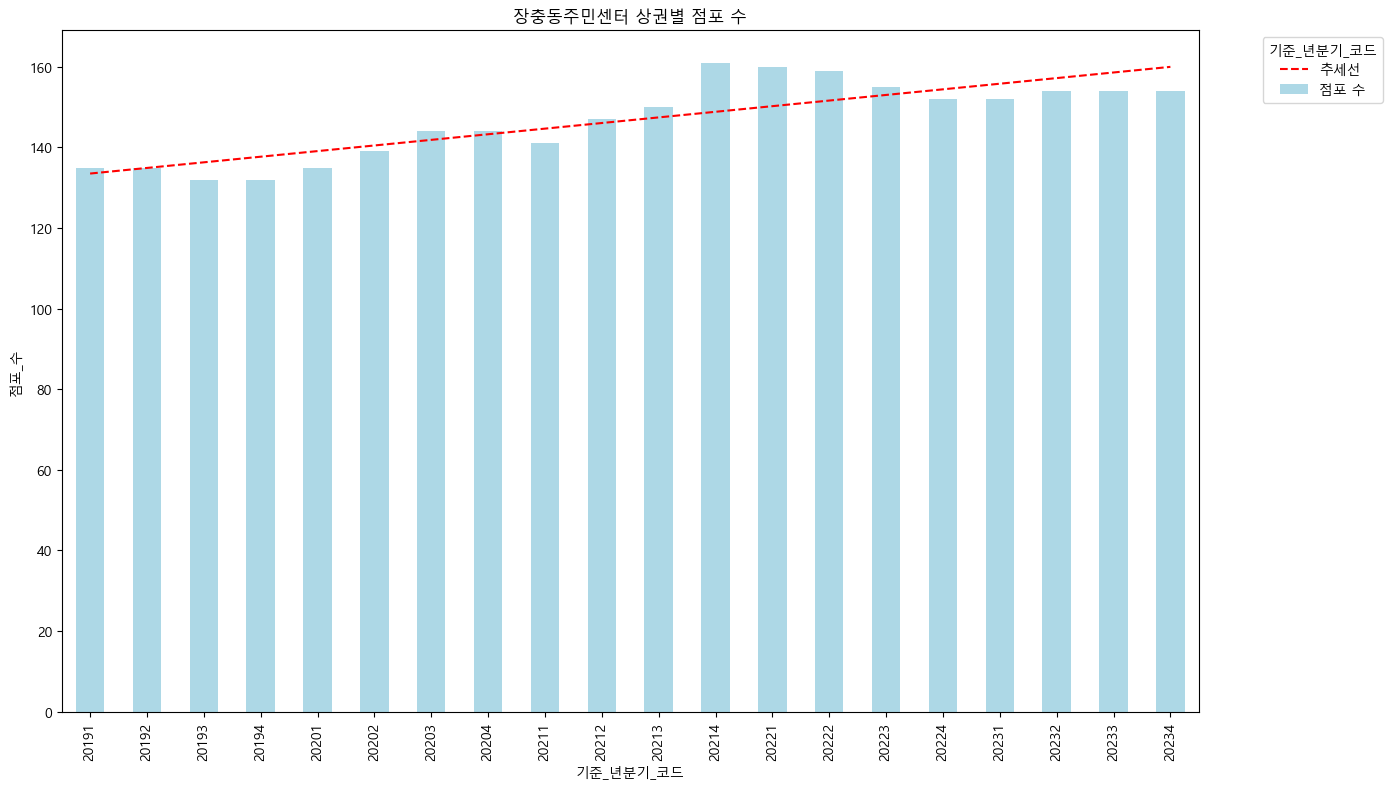

장충초등학교: 추세가 감소하는 경향을 보입니다.


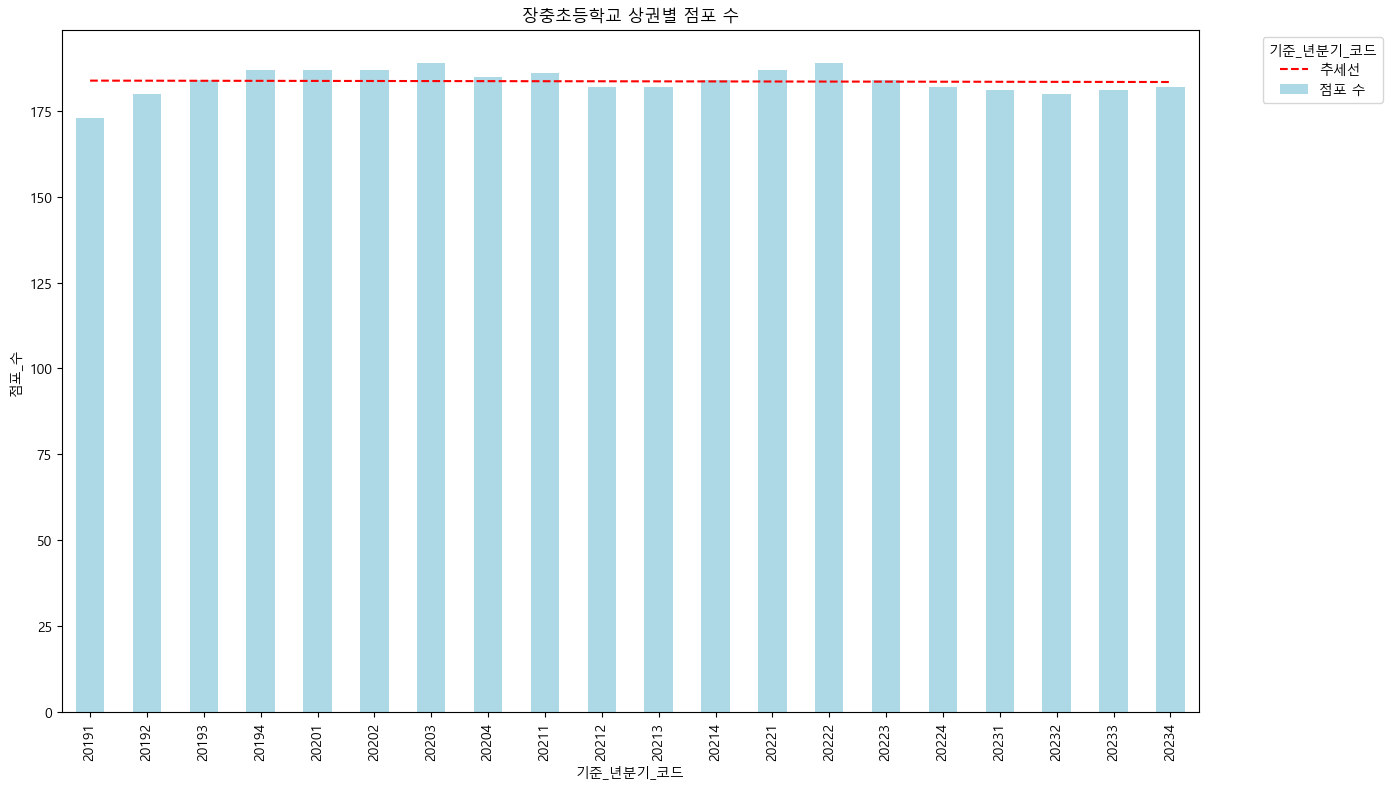

청구역 1번: 추세가 증가하는 경향을 보입니다.


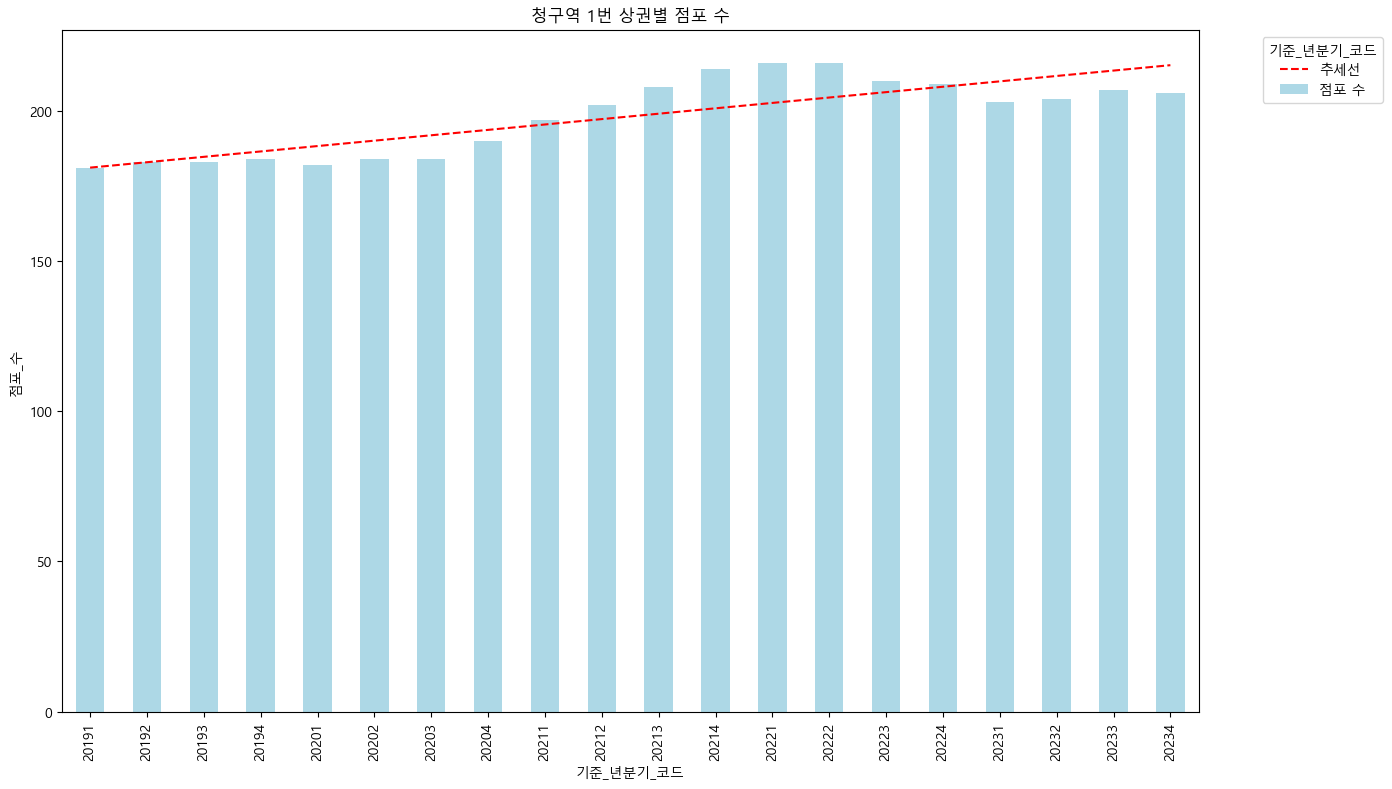

청구역 3번: 추세가 증가하는 경향을 보입니다.


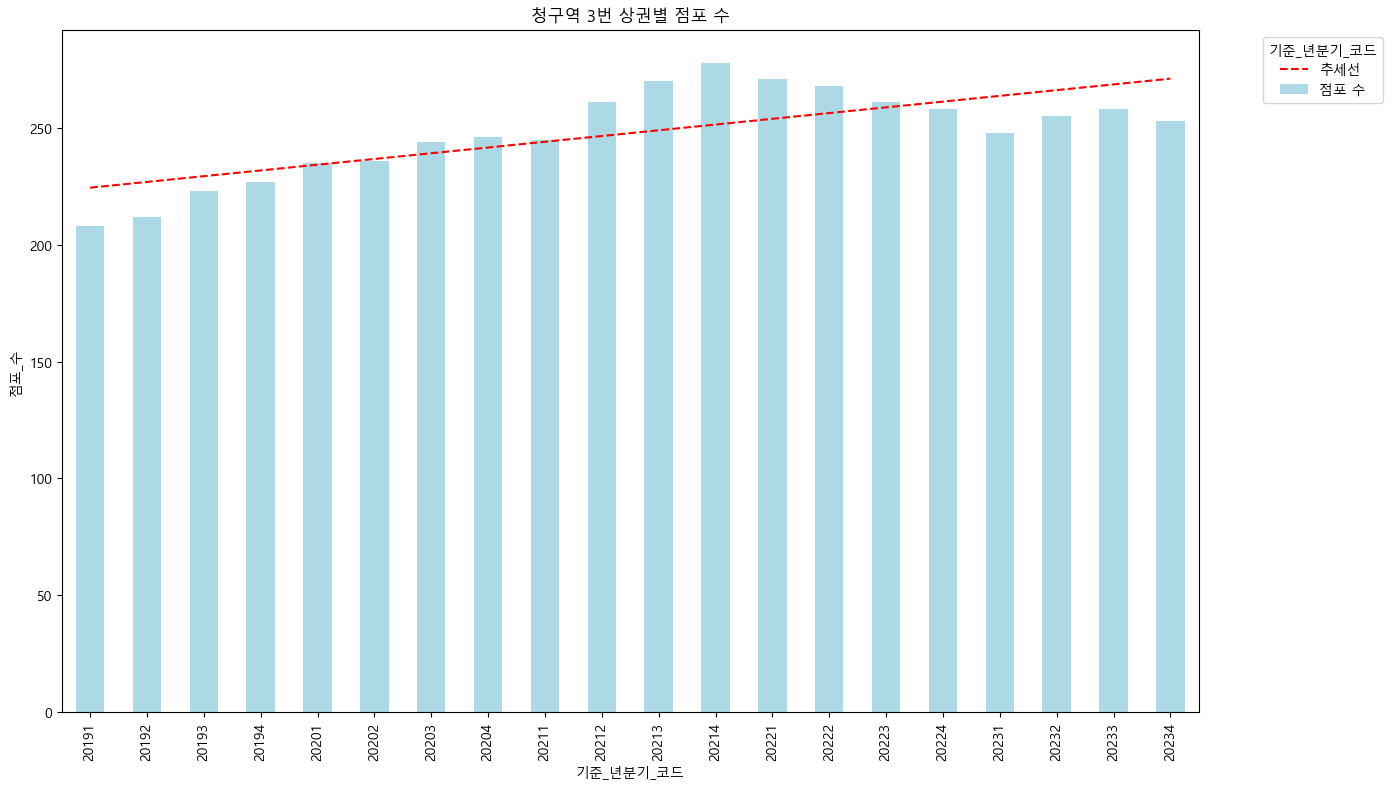

In [54]:
# 기준_년분기_코드를 문자열로 변환
data['기준_년분기_코드'] = data['기준_년분기_코드'].astype(str)

# 상권_코드_명별, 기준_년분기_코드별 점포_수 합계 계산
sales_sum = data.groupby(['상권_코드_명', '기준_년분기_코드'])['점포_수'].sum().unstack()

# 상권_코드_명별로 개별 그래프 생성
for name, group in sales_sum.iterrows():
    plt.figure(figsize=(14, 8))
    group.plot(kind='bar', color='lightblue', label='점포 수')

    # 추세선 추가 (예외 처리 포함)
    try:
        x = np.arange(len(group.index))
        y = group.values

        # 데이터 정규화
        x_norm = (x - np.mean(x)) / np.std(x)
        y_norm = (y - np.mean(y)) / np.std(y)

        z = np.polyfit(x_norm, y_norm, 1)
        p = np.poly1d(z)
        plt.plot(group.index, np.polyval(z, x_norm) * np.std(y) + np.mean(y), "r--", label='추세선')

        # 추세가 증가하는지 여부 출력
        if z[0] > 0:
            print(f"{name}: 추세가 증가하는 경향을 보입니다.")
        else:
            print(f"{name}: 추세가 감소하는 경향을 보입니다.")
    except np.linalg.LinAlgError:
        print(f"LinAlgError: 추세선 계산 실패 ({name})")

    plt.title(f'{name} 상권별 점포 수')
    plt.xlabel('기준_년분기_코드')
    plt.ylabel('점포_수')
    plt.legend(title='기준_년분기_코드', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Y축을 정수 형식으로 설정
    y_formatter = ScalarFormatter(useOffset=False)
    y_formatter.set_scientific(False)
    plt.gca().yaxis.set_major_formatter(y_formatter)

    # 그래프 출력
    plt.show()